<!-- PELICAN_BEGIN_SUMMARY -->

This notebook aims to provide a basic example of how to run a variety of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) and [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) codes in [Python](https://www.python.org/). It won't go into detail about MCMC methods in general, and assumes a bit of knowledge about them, nor will it discuss all the various bells-and-whistles that each sampler can use, but it will hopefully help people get started with writing a sampler code using an understandable (albeit "toy") example. A very nice, quite similar, article on this topic by [Jake VanderPlas](http://vanderplas.com/) can be found [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). There are also very good [online notes](http://people.duke.edu/~ccc14/sta-663-2017/20A_MCMC.html) from the _Computational Statistics and Statistical Computing_ course at [Duke University](https://www.duke.edu/) by [Cliburn Chan](https://genome.duke.edu/directory/cbb-faculty/cliburn-chan-phd) & [Janice McCarthy](https://scholars.duke.edu/person/janice.mccarthy), covering some of this material (including [PyMC3](http://people.duke.edu/~ccc14/sta-663-2017/19A_PyMC3.html) and [PyStan](http://people.duke.edu/~ccc14/sta-663-2017/19B_Pystan.html#estimating-parameters-of-a-linear-regression-model) examples that are very similar to what is covered here). Section 2 of [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757) gives a nice summary of the advantages and disadvantages of some of the algorithms shown here.

This code within this notebook is designed to work for Python 3. An older version that should be compatible with Python 2 can be found [here](https://github.com/mattpitkin/samplers-demo/blob/ac1c8151c5a8c1a3c2b19b5edb57902a4926651f/content/downloads/notebooks/Samplers.ipynb).

<!-- PELICAN_END_SUMMARY -->

You can jump straight to the examples for the different samplers with the links below:

[**MCMC samplers**](#MCMC-samplers):
  1. [emcee](#emcee)
  2. [PyMC3](#PyMC3)
  3. [TensorFlow Probability](#TensorFlow-Probability)
  4. [PyMC4](#PyMC4)
  5. [Zeus](#Zeus)
  6. [PyStan](#PyStan)
  7. [PyJAGS](#PyJAGS)

[**Nested samplers**](#Nested-Sampling):
  1. [Nestle](#Nestle)
  2. [CPNest](#CPNest)
  3. [dynesty](#dynesty)
  4. [UltraNest](#UltraNest)
  5. [PyMultiNest](#PyMultiNest)
  6. [DNest4](#DNest4)
  7. [PyPolyChord](#PyPolyChord)

## Background

MCMC methods are most often used in the context of Bayesian parameter estimation, e.g., you have a model, $y$, defined by a set of parameters, ${\vec{\theta}}$, with certain prior probability distributions $p(\vec{\theta}|I)$, and you want to sample from the marginalised posterior probability distributions on those parameters given some data, $\mathbf{d}$, and a particular [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function), $p(\mathbf{d}|\vec{\theta},I)$, ($I$ is just a substitute for all the implicit assumptions that have gone into defining our model). From Bayes theorem we have the joint posterior on the whole set of parameters,

$$
p(\vec{\theta}|\mathbf{d},I) = \frac{p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I)}{p(\mathbf{d}|I)},
$$

with marginalised posteriors on an individual parameter, say $\theta_1$, given by nested integrals over all other parameters,

$$
p(\theta_1|\mathbf{d},I) = \frac{1}{p(\mathbf{d}|I)}\int^{\forall \theta_i \in (\vec{\theta}\neq \theta_1)} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

($\forall \theta_i \in (\vec{\theta}\neq \theta_1)$ can be translated into "for all parameters $\theta_i$ in $\vec{\theta}$ that are not equal to $\theta_1$). $p(\mathbf{d}|I)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood), or *evidence*, for the data, and is given by

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

which will be discussed below in relation to [nested sampling](#Nested-Sampling).

This is the only context I (and probably many people in the physical sciences) have encountered using MCMC methods, and is the context I will use below.

## Toy model

The very basic example that I will use to demonstrate coding up the samplers is that of sampling from the posteriors of two parameters, $m$ and $c$, defining the model:

$$
y(\mathbf{x};m,c) = m\mathbf{x} + c,
$$

where $\mathbf{x}$ is a vector of values of $x$. This is basically fitting the gradient and $y$-intercept of a straight line, which should be fairly familiar as [linear regression](https://en.wikipedia.org/wiki/Linear_regression), and is obviously a solved problem (*assuming uniform priors!*) using, e.g., [least squares fitting](https://en.wikipedia.org/wiki/Linear_least_squares_%29mathematics%29). But, this provides a simple example that can hopefully be extended to more realistics scenarios.

Our aim is to produce samples drawn from the marginalised posteriors $p(m|\mathbf{d},I)$, and $p(c|\mathbf{d},I)$.

The vector of data samples, $\mathbf{d}$, will consist of the model defined at a set of $M$ values, $\mathbf{x}$, with additive Gaussian noise of known standard deviation, i.e., data point $i$ will be defined by

$$
d_i = y(x_i;m,c) + n_i,
$$

with

$$
n_i \sim N(0, \sigma_i),
$$

which means the noise is drawn from a [Gaussian (or Normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution) of zero mean and standard deviation of $\sigma_i$.

> **Note**: I'll generally use the term [Gaussian distribution](https://en.wikipedia.org/wiki/Normal%5fdistribution)
> rather than "Normal" distribution, as this it what I first heard it called. But, in many packages discussed below
> "Normal" is the more common word for the distribution.

### Setting the likelihood

Given the above choice of noise, a sensible (and fairly standard) likelihood function for a data point given values of $m$ and $c$, will be given by a Gaussian distribution of the form

$$
p(d_i|m,c,I) = \left(2\pi\sigma_i^2\right)^{-1/2} \exp{\left(-\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)},
$$

and the joint likelihood for the whole dataset of $M$ points (assuming independent noise) will be the product of the individual likelihoods

$$
p(\mathbf{d}|m,c,I) = \prod_{i=1}^M p(d_i|m,c,I) = \left(2\pi\right)^{-M/2}\left(\prod_{i=1}^M \sigma_i^{-1} \right) \exp{\left(-\sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2} \right)}
$$

When computing likelihoods, numerical considerations mean that one almost always works with the natural logarithm of the likelihood, so we have

$$
\ln{p(\mathbf{d}|m,c,I)} \equiv \log{L} = -\frac{M}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^M \sigma_i\right) - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}
$$

For many cases we can ignore the terms that do not include our required parameters when sampling from their marginalised likelihoods (as they will just be constants), so often the log-likelihood can be set to be

$$
\log{L} = - \sum_{i=1}^M\frac{\left[(d_i - y(x_i;m,c)\right]^2}{2\sigma_i^2}.
$$

> **Note**: If wanting to evaluate the marginal likelihood for the data (e.g., using nested sampling, which is
> discussed later) to use it for [model comparison](https://en.wikipedia.org/wiki/Bayes%5ffactor), the constants
> may be required.

### Setting the prior

In addition to the likelihood, we need to define [prior](https://en.wikipedia.org/wiki/Prior_probability) distributions on the parameters. To demonstrate a couple of different, and reasonably common, priors, I'll use a uniform probability distribution for the prior on $m$ and a Gaussian probability distribution for the prior on $c$:

$$
p(m|\mu_m,\sigma_m,I) = \frac{1}{\sqrt{2\pi\sigma_m^2}}\exp{\left(-\frac{(m-\mu_m)^2}{2\sigma_m^2}\right)},
$$

and

$$
p(c|c_{\rm min}, c_{\rm max}) = \frac{1}{c_{\rm max}-c_{\rm min}}.
$$

In our example we'll set:

 * $\mu_m = 0$ and $\sigma_m = 10$,
 * $c_{\rm min} = -10$ and $c_{\rm max} = -10$.
 
> **Note**: These priors are not intended to be the [least informative](https://en.wikipedia.org/wiki/Prior%5fprobability#Uninformative%5fpriors) for the parameterisation that we have, but
> are just chosen for demonstration purposes to show how to code up two different distributions. A better prior
> for this particular problem might be the one discussed [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#The-Prior), which 
> could be coded up for PyMC3 using the example [here](http://docs.pymc.io/notebooks/getting%5fstarted.html#Arbitrary-distributions).

### Creating the data

So, let's get started creating our data. I'll (arbitrarily) use:

 * $m = 3.5$,
 * $c = 1.2$,

for the model and

 * $\mathbf{x} \in [0, 10)$ in $M=100$ uniform steps ($[a,b)$ means [inclusive of $a$, but exclusive of $b$](https://en.wikipedia.org/wiki/Bracket_%28mathematics%29#Intervals)),
 * $\sigma_i = \sigma = 0.5$ (i.e., each noise point is independent, but has the same standard deviation),
 
for the data.

In [1]:
# show plots inline in the notebook
%matplotlib inline

import numpy as np                  # import numpy
from time import time               # use for timing functions

# useful modules!
import sys
import os

# make the plots look a bit nicer with some defaults
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

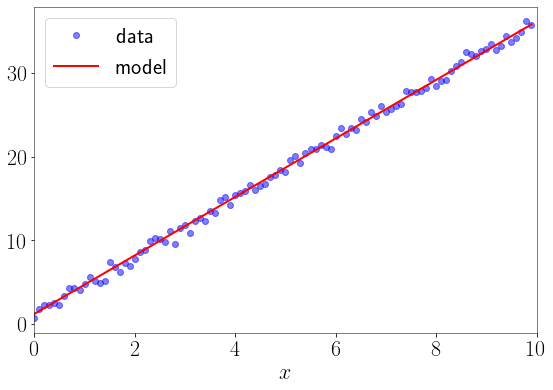

In [2]:
# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

## MCMC samplers

First up I'll deal with MCMC samplers that are purely written in Python, then a couple that are wrappers to other libraries.

### emcee

[emcee](http://dfm.io/emcee/current/) ([Foreman-Mackey _et al_, 2013](https://arxiv.org/abs/1202.3665)) is a Python MCMC implementation that uses an affine invariant ensemble sampler ([Goodman & Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml)). This basically means that it doesn't just evolve a single point in the model parameter space, but evolves and ensemble of points, and steps in the evolution are tuned based on the current state of the ensemble. So, the steps scale naturally (the *affine invariant* bit) as the ensemble closes in on the posterior. This code has been [well used](http://dfm.io/emcee/current/testimonials/) in the astrophysics community (and as an astrophysicist myself I'm showing it as my first example!).

emcee is available on [PyPI](https://pypi.org/) and is [installable](http://dfm.io/emcee/current/user/install/#using-pip) via `pip` with:

```bash
pip install emcee
```

or via [Conda](https://conda.io/en/latest/index.html) [with](https://anaconda.org/conda-forge/emcee):

```bash
conda install -c conda-forge emcee 
```

The source code is available on GitHub [here](https://emcee.readthedocs.io/en/stable/). The example here is very similar to the [line model example](https://emcee.readthedocs.io/en/stable/tutorials/line/) given in the emcee documentation.

First up, we need to define the likelihood function, prior functions, and posterior probability function. These all need to be defined as the natural logarithms of the functions. All the functions take in a sample [tuple](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) or list, where a sample is a vector $\vec{\theta}$ of parameter values, that can be unpacked to give the individual parameter values. Other arguments to the posterior function can be user defined.

#### Posterior

As we do not care about the marginal likelihood, the posterior will just be the product of the likelihood and prior, and will take the following form:

In [3]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

#### Likelihood

The likelihood will take the following form:

In [4]:
def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined

    Note:
        We do not include the normalisation constants (as discussed above).
    """
    
    # unpack the model parameters from the tuple
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5*np.sum(((md - data)/sigma)**2)

#### Prior

The prior function will take the following form:

In [5]:
def logprior(theta):
    """
    The natural logarithm of the prior probability.

    Args:
        theta (tuple): a sample containing individual parameter values

    Note:
        We can ignore the normalisations of the prior here.
    """

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 0.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

#### MCMC set up

We need to decide on an initial number of ensemble points and initialise the samples, i.e., set starting points for them. The initial samples can be drawn from the prior distributions (in the emcee documentation [example](https://emcee.readthedocs.io/en/stable/tutorials/line/) it starts the opposite way round, i.e., with initial samples tightly packed around the true value). We'll choose 100 ensemble points (the number of so-called *walkers*) and initialise them with:

In [6]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Because our initial samples are drawn from the prior it can take time for them to converge on sampling from the posterior distributions that we want. To try and get around this we can run the sampler with a [burn-in](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect007.htm) period (although see, e.g., [here](http://users.stat.umn.edu/~geyer/mcmc/burn.html) or [here](https://www.johndcook.com/blog/2016/01/25/mcmc-burn-in/) for some discussions about whether burn-ins are actually necessary), and we will ignore samples during this burn-in.

> **Note**: Alternative options could be to use some optimisation routine to try and find the posterior mode and start samples at that point, or use all samples, work out an autocorrelation length and thin the samples accordingly so they are uncorrelated (as shown a bit later), which gets rid of correlations during the initial convergence of the samples.

We'll choose a burn-in of 500 samples, and then run the chain for another 500 samples, which will give an output with $(500+500)\times 100 = 100000$ samples.

In [7]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

The sampler first has to be initialised and told the required arguments, including any additional arguments for the posterior function:

In [8]:
import emcee # import the emcee package

print('emcee version: {}'.format(emcee.__version__))

# for bookkeeping set number of likelihood calls to zero
loglikelihood.ncalls = 0

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

emcee version: 3.0.2


Now the sampler can be run, and the burn-in samples removed, with:

In [9]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 7.823524475097656 seconds


Now we can plot the resulting posteriors using [corner.py](http://corner.readthedocs.io/en/latest/), and also show smoothed versions using a Gaussian [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation).

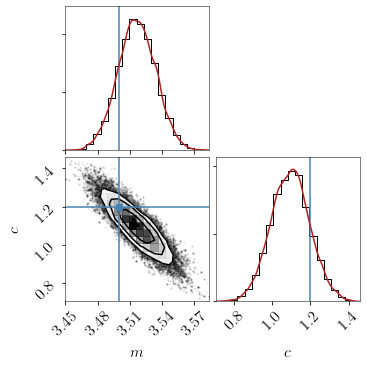

In [10]:
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]

    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# make plot
plotposts(samples_emcee)

In [11]:
# lets store some results for showing together later
resdict = {}

resdict['memcee_mu'] = np.mean(samples_emcee[:,0])     # mean of m samples
resdict['memcee_sig'] = np.std(samples_emcee[:,0])     # standard deviation of m samples
resdict['cemcee_mu'] = np.mean(samples_emcee[:,1])     # mean of c samples
resdict['cemcee_sig'] = np.std(samples_emcee[:,1])     # standard deviation of c samples
resdict['ccemcee'] = np.corrcoef(samples_emcee.T)[0,1] # correlation coefficient between parameters

The time to convergence can depend greatly on how the initial points are set up, so if you have a better guess as to location and shape of the posterior, then using those guesses is advised. But, beware overtuning! emcee has some handy utilities to draw samples from around an initial guess. In the example below I show the use of the [`sample_ball()`](http://dfm.io/emcee/current/api/#emcee.utils.sample_ball) function, which creates a ball of samples assuming no correlations between parameters. However, if you knew that your parameter uncertainties had a particular covariance, you could use `sample_ellipsoid()` to generate a sample cloud using a supplied covarance matrix.

In [12]:
from emcee.utils import sample_ball
m_guess, c_guess = 1., 1. # guess at the mean of the distribution
m_std, c_std = 1., 1.     # guess at the width of the distribution

# generate samples from a ball based on those guesses
inisamples = sample_ball((m_guess, c_guess), (m_std, c_std), size=Nens)

In [13]:
# reset so we don't pick up the result from earlier
sampler.reset()

# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 7.7211644649505615 seconds


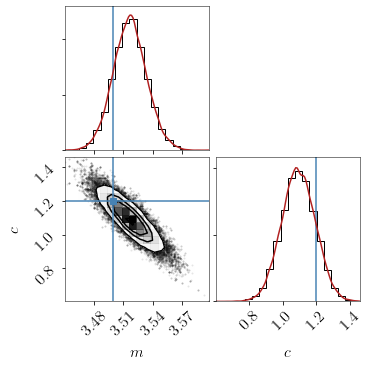

In [14]:
# plot the resulting posteriors
plotposts(samples_emcee)

Once the sampler has settled, the samples that come out of MCMC will be drawn from the posterior. However, even in the best of situations, draws which are adjacent are often correlated with each other. The number of "independent" samples, that is, fully independent draws from the posterior can be much fewer than the samples in hand.

The emcee EnsembleSamler class has an inbuilt function, [`get_autocorr_time()`](https://emcee.readthedocs.io/en/stable/user/sampler/#emcee.EnsembleSampler.get_autocorr_time), to calculate the auto-correlation length (ACL) (or time) - this is an estimate the number of samples between independent samples in the chain. You can use this number to estimate convergence of chains, and also to thin out chains to produce independent samples.

N/50 = 20;
tau: [16.7963659  22.39381409]


The autocorrelation length for m is 16.796365900451075 and c is 22.393814085020843
Number of independent samples is 2300
Effective samples per second: 297


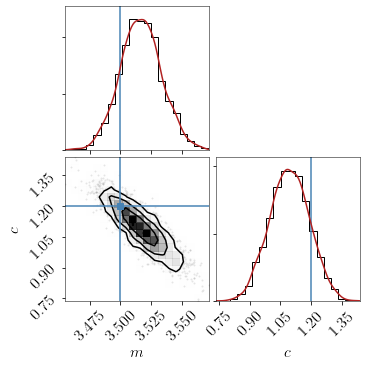

In [15]:
m_acl, c_acl = sampler.get_autocorr_time(quiet=True)
print("The autocorrelation length for m is {0} and c is {1}".format(m_acl, c_acl))

# thin out the chain
samples_emcee = sampler.chain[:, Nburnin::int(max([m_acl, c_acl])), :].reshape((-1, ndims))
print("Number of independent samples is {}".format(len(samples_emcee)))

resdict['essemcee'] = int(len(samples_emcee) / timeemcee)
print("Effective samples per second: {}".format(resdict['essemcee']))

# plot the resulting posteriors
plotposts(samples_emcee)

In practice, if you have a minimum number of independent samples that you require then you can repeatedly run the sampler, checking the ACL each time (and maybe adjusting the `c` input parameter for `get_autocorr_time()`), until you have collected the required number.

Checking the ACL is something that can be done for any of the samplers discussed in the rest of this notebook. Different sampling methods can lead to different ACLs, and methods that may take more time per sample might end up having shorter ACLs. So, examining the various trade-offs between overall speed and the final number of independent samples can be worthwhile.

### PyMC3

[PyMC3](http://docs.pymc.io/) ([Salvatier, Wiecki & Fonnesbeck, 2016](https://peerj.com/articles/cs-55/)) is a Python MCMC implementation that can use a variety of modern sampling method, including "No-U-turn sampling" (NUTS) ([Hoffman & Gellman, 2014](http://www.jmlr.org/papers/v15/hoffman14a.html)) and [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) ([Duane _et al_, 1987](http://www.sciencedirect.com/science/article/pii/037026938791197X)), both of which make use of the gradient of the posterior to efficiently sample the space. An example of getting started using PyMC3 can be found [here](https://docs.pymc.io/notebooks/getting_started#A-Motivating-Example:-Linear-Regression), and upon which this example is based.

This code can also be [installed](http://docs.pymc.io/#installation) using `pip` with:

```bash
pip install pymc3
```

or with [Conda](https://conda.io/docs/index.html) [with](https://anaconda.org/conda-forge/pymc3):

```bash
conda install -c conda-forge pymc3
```

and the source is available on GitHub [here](https://github.com/pymc-devs/pymc3).

The majority of distributions that can be used for priors and likelihood functions are [predefined](http://docs.pymc.io/api/distributions.html) in PyMC3, so you do not have to worry about writing them yourself (although you can create your [own custom distribution](http://docs.pymc.io/notebooks/getting_started.html#Arbitrary-distributions)).

Note that in PyMC3 the prior and likelihood distributions have to be defined within the [context](http://book.pythontips.com/en/latest/context_managers.html) of a PyMC3 [`Model()` class](https://docs.pymc.io/api/model.html#module-pymc3.model), and cannot be defined outside that context (the `with` statment). Therefore, to set up the model we can't just use the `straight_line()` function defined above, but can do the following:

In [16]:
import pymc3 as pm # import PyMC3

print('PyMC3 version: {}'.format(pm.__version__))

# set the PyMC3 model
linear_model = pm.Model()

with linear_model:
    # set prior parameters
    cmin = -10. # lower range of uniform distribution on c
    cmax = 10.  # upper range of uniform distribution on c
    
    mmu = 0.     # mean of Gaussian distribution on m
    msigma = 10. # standard deviation of Gaussian distribution on m
    
    # set priors for unknown parameters
    cmodel = pm.Uniform('c', lower=cmin, upper=cmax) # uniform prior on y-intercept
    mmodel = pm.Normal('m', mu=mmu, sd=msigma)       # Gaussian prior on gradient
    
    sigmamodel = sigma # set a single standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel

    # Gaussian likelihood (sampling distribution) of observations, "data"
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=data)

PyMC3 version: 3.9.2


Now we can perform the sampling. By default, for continuous variables like we have, the [sampling step method](http://docs.pymc.io/api/inference.html#step-methods) will use [NUTS](http://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts), but the method can be chosen manually. We'll run with 1000 samples, and tune (like the burn-in discussed [above](#MCMC-set-up)) with 1000 samples (discarding these tuning samples):

In [17]:
%%capture
Nsamples = 1000 # final number of samples
Ntune = 1000    # number of tuning samples

# perform sampling
t0 = time()
with linear_model:
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True); # perform sampling
t1 = time()

timepymc3 = (t1-t0)

In [18]:
print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))

Time taken to run 'PyMC3' is 21.19169330596924 seconds


Now, let's extract the samples from the `trace` object and make a corner plot!

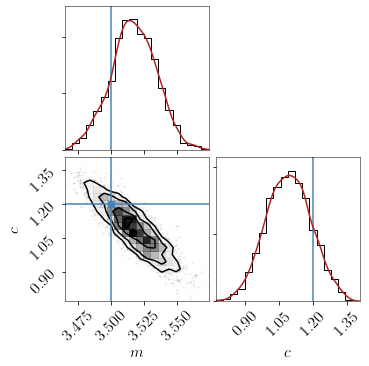

In [19]:
samples_pymc3 = np.vstack((trace['m'], trace['c'])).T

resdict['mpymc3_mu'] = np.mean(samples_pymc3[:,0])      # mean of m samples
resdict['mpymc3_sig'] = np.std(samples_pymc3[:,0])      # standard deviation of m samples
resdict['cpymc3_mu'] = np.mean(samples_pymc3[:,1])      # mean of c samples
resdict['cpymc3_sig'] = np.std(samples_pymc3[:,1])      # standard deviation of c samples
resdict['ccpymc3'] = np.corrcoef(samples_pymc3.T)[0,1]  # correlation coefficient between parameters

plotposts(samples_pymc3)

In [20]:
# calculate the autocorrelation length
acts = []
for param in ["m", "c"]:
    acts.append(emcee.autocorr.integrated_time(trace[param]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esspymc3'] = int((len(samples_pymc3) / np.max(acts)) / timepymc3)
print("Effective samples per second: {}".format(resdict['esspymc3']))

Autocorrelation length for 'm' is [5.24834455]
Autocorrelation length for 'c' is [6.25573211]
Maximum autocorrelation length is 6.3
Effective samples per second: 15


### TensorFlow Probability

[TensorFlow Probability](https://www.tensorflow.org/probability/) (TFP) is a probabilistic modelling framework built upon the [TensorFlow](https://www.tensorflow.org/) library. TFP contains some samplers for performing MCMC. At the time of writing TFP is still fairly new, and [currently includes](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/mcmc) a Hamiltonian MC sampler, a Metropolis-Hastings sampler, and a slice sampler.

TFP can be [installed](https://github.com/tensorflow/probability#stable-builds) from [PyPI](https://pypi.org/) via `pip` with:

```bash
pip install tensorflow tensorflow-probability
```

where `tensorflow` must be explicitly installed as it's not a dependency of `tensorflow-probability`.

Using TFP for MCMC sampling has some similarites to PyMC3, however it can be fairly opaque, and (for me at least!) non-intuitive. The example given does not come with a detailed explanation of that I've constructions used, because I don't have any in-depth knowlegde of them. It was mainly cobbled together by looking at the example given [here](https://www.tensorflow.org/probability/examples/Eight_Schools).

Firstly, we can set up the probablistic model (with a [`JointDistributionSequential`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionSequential) class) that contains the prior distributions on the parameters of interest and a `lambda` function defining the likelihood function, within which we write out the straight line model for the data. Some things to be aware of are: the arguments to the `lambda` function defining the likelihood must be given in the opposite order to that in which those arguments are placed within the `JointDistributionSequential` class; the `name` of the [`Independent`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Independent) distribution that holds the likelihood function should be the same as the name of the variable that holds the data. 

In [21]:
# import TensorFlow probability
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import tensorflow as tf

cmin = -10. # lower range of uniform distribution on c
cmax = 10.  # upper range of uniform distribution on c

mmu = 0.     # mean of Gaussian distribution on m
msigma = 10. # standard deviation of Gaussian distribution on m

# convert x values and data to 32 bit float
xtfp = x.astype(np.float32)  # x is being use globally here
datatfp = data.astype(np.float32)

# set model - contains priors and the expected linear model
model = tfd.JointDistributionSequential([
  tfd.Normal(loc=mmu, scale=msigma, name="m"),  # m prior
  tfd.Uniform(cmin, cmax, name="c"),  # c prior
  lambda c, m: (tfd.Independent(
        tfd.Normal( # the Normal likelihood function
            loc=(m[..., tf.newaxis] * xtfp + c[..., tf.newaxis]), # the straight line model
            scale=sigma  # the data standard deviation
        ),
        name="datatfp",  # the name of the variable holding the data
        reinterpreted_batch_ndims=1,
    ))
])

print('TensorFlow version: {}'.format(tf.__version__))
print('TensorFlow Probability version: {}'.format(tfp.__version__))

TensorFlow version: 2.5.0-dev20200629
TensorFlow Probability version: 0.11.0-dev20200630


Next, the probablistic model must be wrapped in a function that takes in values of the parameters being sampled and returns the probability.

In [22]:
def target_log_prob_fn(mvalue, cvalue):
    return model.log_prob(
        (mvalue, cvalue, datatfp)
    )

We can now set up the sampler and here we'll use the No U-turn Sampler (NUTS). For the set up of the [`NoUTurnSampler`](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler) we have to specify a step size (i.e., the size of the proposals). Some experimentation for our particular case shows a step size of 0.01 is reasonable, but it won't work for any example and most be tuned by hand. It also means that if different parameters have quite different dynamic ranges this method will not work well (it may produce jumps that are alway for too big or small for certain sets of parameters).

Wrapping the sampling within a function (`do_sampling()`) with the `@tf.function` decorator compiles the model and means it runs far faster than without the wrapper.

We'll draw initial values of the `m` and `c` parameters from distributions that match their priors.

In [23]:
Nsamples = 4000 # final number of samples
Nburn = 4000    # number of tuning samples

# set up Hamiltonian MC (within TensorFlow function to speed up computation)
@tf.function(autograph=False)
def do_sampling():
    # set initial state (random draw from prior)
    qc = tf.random.uniform([], minval=cmin, maxval=cmax, name="init_c")
    qm = tf.random.normal([], stddev=msigma, mean=mmu, name="init_m")

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.01,
        num_leapfrog_steps=5,
    )

    return tfp.mcmc.sample_chain(
        num_results=Nsamples,
        current_state=[qm, qc],
        kernel=hmc_kernel,
        num_burnin_steps=Nburn,
    )

t0 = time()
states, kernel_results = do_sampling()
t1 = time()

timetfp = (t1-t0)

# extract the samples
ms, cs = states

# convert output states to numpy arrays
samples_tfp = np.vstack((ms.numpy(), cs.numpy())).T

num_accepted = np.sum(kernel_results.is_accepted)
print("Acceptance rate: {}".format(num_accepted / Nsamples))  # print out acceptance rate

/opt/conda/envs/python37/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.98575


In [24]:
print("Time taken to run 'TFP' is {} seconds".format(timetfp))

Time taken to run 'TFP' is 11.862120628356934 seconds


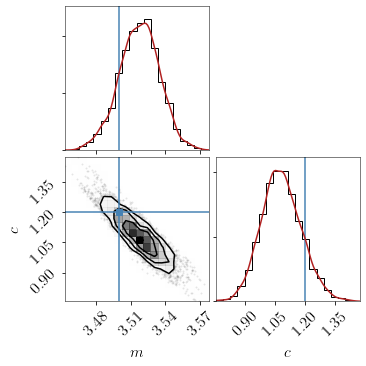

In [99]:
resdict['mtfp_mu'] = np.mean(samples_tfp[:,0])      # mean of m samples
resdict['mtfp_sig'] = np.std(samples_tfp[:,0])      # standard deviation of m samples
resdict['ctfp_mu'] = np.mean(samples_tfp[:,1])      # mean of c samples
resdict['ctfp_sig'] = np.std(samples_tfp[:,1])      # standard deviation of c samples
resdict['cctfp'] = np.corrcoef(samples_tfp.T)[0,1]  # correlation coefficient between parameters

plotposts(samples_tfp)

In [26]:
# calculate the autocorrelation length
acts = []
for i, param in enumerate(["m", "c"]):
    acts.append(emcee.autocorr.integrated_time(samples_tfp[:, i]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esstfp'] = int((len(samples_tfp) / np.max(acts)) / timetfp)
print("Effective samples per second: {}".format(resdict['esstfp']))

Autocorrelation length for 'm' is [75.31698862]
Autocorrelation length for 'c' is [11.03326329]
Maximum autocorrelation length is 75.3
Effective samples per second: 4


### PyMC4

[PyMC4](https://github.com/pymc-devs/pymc4) is (at the time of writing) very much in its infancy as a successor to [PyMC3](#PyMC3). It is essentially a wrapper to [TensorFlow Probability](#TensorFlow-Probability) and currently defaults to use the NUTS sampler. It can be [installed](https://github.com/pymc-devs/pymc4#installation-instructions) from the github page via:

```bash
pip install --user git+https://github.com/pymc-devs/pymc4.git#egg=pymc4
```

This example was aided by the nice tutorial given [here](http://krasserm.github.io/2020/04/25/getting-started-with-pymc4/).

Unlike PyMC3, we don't need to define
We first need to initialilise the probabilistic model that we use (we'll convert our data and dependent variable to TensorFlow tensor objects, and explicitly define their types). Unlike PyMC3, we don't use a context manager within which the model gets defined, but we do need to give the model function a `model` decorator:

In [27]:
# import PyMC4
import pymc4 as pm4
import tensorflow as tf

cmin = -10.  # lower range of uniform distribution on c
cmax = 10.   # upper range of uniform distribution on c

mmu = 0.      # mean of Gaussian distribution on m
msigma = 10.  # standard deviation of Gaussian distribution on m

# convert x values and data to tensors
xtensor = tf.convert_to_tensor(x, dtype=tf.float32)
datatensor = tf.convert_to_tensor(data, dtype=tf.float32)

# model must be wrapped with the model decorator
@pm4.model
def model(x, data, sigma=sigma):
    cvalue = yield pm4.Uniform(name='c', low=cmin, high=cmax)  # prior on c
    mvalue = yield pm4.Normal(name='m', loc=mmu, scale=msigma) # prior on m
    
    # the straight line model
    mu = cvalue + mvalue * x
    
    # the likelihood
    yield pm4.Normal(name='t_obs', loc=mu, scale=sigma, observed=data)

We can then run the sampler, which defaults to using NUTS:

In [28]:
Nsamples = 2000  # final number of samples
Nburn = 2000     # number of tuning samples

# perform the sampling
t0 = time()
pymc4_trace = pm4.sample(
    model(xtensor, datatensor),
    num_chains=1,
    burn_in=Nburn,
    num_samples=Nsamples,
)
t1 = time()

timepymc4 = t1 - t0

print("Time taken to run 'PyMC4' is {} seconds".format(timepymc4))

Time taken to run 'PyMC4' is 58.172147035598755 seconds


The output is an [ArviZ](https://arviz-devs.github.io/arviz/) [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object. We can extract the posterior samples and plot them with:

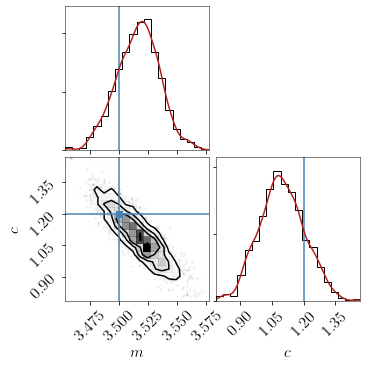

In [100]:
samples_pymc4 = np.vstack((
    pymc4_trace.posterior["model/m"].data.flatten(),
    pymc4_trace.posterior["model/c"].data.flatten()
)).T

resdict['mpymc4_mu'] = np.mean(samples_pymc4[:,0])      # mean of m samples
resdict['mpymc4_sig'] = np.std(samples_pymc4[:,0])      # standard deviation of m samples
resdict['cpymc4_mu'] = np.mean(samples_pymc4[:,1])      # mean of c samples
resdict['cpymc4_sig'] = np.std(samples_pymc4[:,1])      # standard deviation of c samples
resdict['ccpymc4'] = np.corrcoef(samples_pymc4.T)[0,1]  # correlation coefficient between parameters

plotposts(samples_pymc4)

In [30]:
# calculate the autocorrelation length
acts = []
for i, param in enumerate(["m", "c"]):
    acts.append(emcee.autocorr.integrated_time(samples_pymc4[:, i]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esspymc4'] = int((len(samples_pymc4) / np.max(acts)) / timepymc4)
print("Effective samples per second: {}".format(resdict['esspymc4']))

Autocorrelation length for 'm' is [7.18105571]
Autocorrelation length for 'c' is [8.11345439]
Maximum autocorrelation length is 8.1
Effective samples per second: 4


### Zeus

[Zeus](https://zeus-mcmc.readthedocs.io/en/latest/) ([Karamanis & Beutler, 2020](https://arxiv.org/abs/2002.06212)) is a pure Python MCMC code that uses ensemble slice sampling. It is very similar in usage to [emcee](#emcee). Zeus is available via PyPI and can be installed using pip with:

```bash
pip install zeus-mcmc
```

The Zeus source code is available on [Github](https://github.com/minaskar/zeus).

The Zeus documentation gives a nice [example of fitting a straight line](https://zeus-mcmc.readthedocs.io/en/latest/notebooks/datafit.html). The interface is so similar to [emcee](#emcee) that we can reuse the `logprior`, `loglikelihood` and `logposterior` functions that we used in the case (I won't both redefining them, so you'll have to scroll back up!). So, that just leaves the sampling. We will just leave any tunable parameters at their default values, but you can choose between a few different proposal distributions.

In [31]:
import zeus

print('Zeus version: {}'.format(zeus.__version__))

ndim = 2          # Number of parameters/dimensions (e.g. m and c)
Nens = 100        # for consistency with the emcee example we'll use 100 
Nburn = 500       # burn-in samples
Nsamples = 500    # Nsamples

# set the initial samples (we'll draw from the prior)
mini = np.random.normal(mmu, msigma, Nens) # initial m points
cini = np.random.uniform(cmin, cmax, Nens) # initial c points
inisamples = np.array([mini, cini]).T # initial samples

# Initialise the sampler
sampler = zeus.sampler(Nens, ndim, logposterior, args=[data, sigma, x])

t0 = time()
# Run the sampler
sampler.run_mcmc(inisamples, Nburn + Nsamples)
t1 = time()

timezeus = t1 - t0

# print summary diagnostics
sampler.summary

Initialising ensemble of 100 walkers...
Sampling progress :   0%|          | 0/1000 [00:00<?, ?it/s]

Zeus version: 1.0.7


Sampling progress : 100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 100
Number of Tuning Generations: 8
Scale Factor: 0.755347
Mean Integrated Autocorrelation Time: 2.87
Effective Sample Size: 34796.12
Number of Log Probability Evaluations: 728496.0
Effective Samples per Log Probability Evaluation: 0.047764


In [32]:
print("Time taken to run 'Zeus' is {} seconds".format(timezeus))

Time taken to run 'Zeus' is 67.96233248710632 seconds


The `sampler` object has a method to extract the posterior samples and we can discard the burn-in and thin the samples if required.

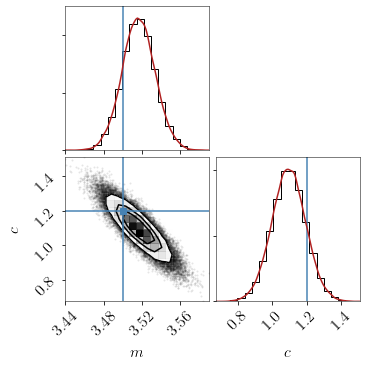

In [33]:
samples_zeus = sampler.get_chain(flat=True, discard=Nburn)

resdict['mzeus_mu'] = np.mean(samples_zeus[:,0])      # mean of m samples
resdict['mzeus_sig'] = np.std(samples_zeus[:,0])      # standard deviation of m samples
resdict['czeus_mu'] = np.mean(samples_zeus[:,1])      # mean of c samples
resdict['czeus_sig'] = np.std(samples_zeus[:,1])      # standard deviation of c samples
resdict['cczeus'] = np.corrcoef(samples_zeus.T)[0,1]  # correlation coefficient between parameters

plotposts(samples_zeus)

In [34]:
# calculate the autocorrelation length
acts = []
for i, param in enumerate(["m", "c"]):
    acts.append(emcee.autocorr.integrated_time(samples_zeus[:, i]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esszeus'] = int((len(samples_zeus) / np.max(acts)) / timezeus)
print("Effective samples per second: {}".format(resdict['esszeus']))

Autocorrelation length for 'm' is [2.98874302]
Autocorrelation length for 'c' is [3.06453072]
Maximum autocorrelation length is 3.1
Effective samples per second: 240


### MCMC wrapper samplers

There are other MCMC samplers that are not pure Python packages, but have a Python-based wrapper to a different library. With these you can't write pure Python model and probability functions, but instead have a create a code string that is then compiled and run using the underlying library functions. We will look at [PyStan](http://pystan.readthedocs.io) and [PyJAGS](https://pyjags.readthedocs.io).

### PyStan

[PyStan](http://pystan.readthedocs.io) is a Python interface to the popular [Stan](http://mc-stan.org/) library. As with [PyMC3](#PyMC3), it uses the modern NUTS and Hamiltonain MC sampling methods. It can be [installed](http://pystan.readthedocs.io/en/latest/getting_started.html#installation) using `pip` with:

```bash
pip install pystan
```

or via Conda [with](https://anaconda.org/conda-forge/pystan):

```bash
conda install -c conda-forge pystan
```

and the source code is available on GitHub [here](https://github.com/stan-dev/pystan).

To define the model and distributions you need to write a code string like this:

In [35]:
# model and distributions for straight line fitting
line_code = """
data {{
    int<lower=0> N;      // number of data points
    real y[N];           // observed data points
    real x[N];           // abscissa points
    real<lower=0> sigma; // standard deviation
}}
parameters {{
    // parameters for the fit
    real m;
    real c;
}}
transformed parameters {{
    real theta[N];
    for (j in 1:N)
    theta[j] = m * x[j] + c; // straight line model
}}
model {{
    m ~ normal({mmu}, {msigma});     // prior on m (gradient)
    c ~ uniform({clower}, {cupper}); // prior on c (y-intercept)
    y ~ normal(theta, sigma);        // likelihood of the data given the model
}}
"""

You can then define the inputs to the `data` section in a dictionary:

In [36]:
# set the data and the abscissa
linear_data = {'N': M,          # number of data points
               'y': data,       # observed data (converted from numpy array to a list)
               'x': x,          # abscissa points (converted from numpy array to a list)
               'sigma': sigma}  # standard deviation

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [37]:
%%capture
import pystan # import PyStan

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0    # mean of Gaussian prior distribution for m
linedict['msigma'] = 10  # standard deviation of Gaussian prior distribution for m
linedict['clower'] = -10 # lower bound on uniform prior distribution for c
linedict['cupper'] = 10  # upper bound on uniform prior distribution for c

t0 = time()
sm = pystan.StanModel(model_code=line_code.format(**linedict)); # compile model
t1 = time()

timepystancomp = (t1-t0)

t0 = time()
fit = sm.sampling(data=linear_data, iter=Nsamples, chains=chains); # perform sampling
t1 = time()

timepystan = (t1-t0)

COMPILING THE C++ CODE FOR MODEL anon_model_15aa743a6e306b61e6880db7be28ca62 NOW.


In [38]:
print('PyStan version: {}'.format(pystan.__version__))

print("Time taken to comile 'PyStan' model is {} seconds".format(timepystancomp))
print("Time taken to run 'PyStan' is {} seconds".format(timepystan))

PyStan version: 2.19.1.1
Time taken to comile 'PyStan' model is 179.64443612098694 seconds
Time taken to run 'PyStan' is 0.8871889114379883 seconds


PyStan does have a plotting function (you could run `fit.plot()`), but we'll extract the chains and use `corner.py`:

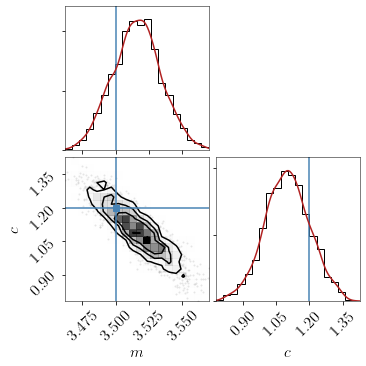

In [39]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

samples_pystan = np.vstack((la['m'], la['c'])).T

resdict['mpystan_mu'] = np.mean(samples_pystan[:,0])      # mean of m samples
resdict['mpystan_sig'] = np.std(samples_pystan[:,0])      # standard deviation of m samples
resdict['cpystan_mu'] = np.mean(samples_pystan[:,1])      # mean of c samples
resdict['cpystan_sig'] = np.std(samples_pystan[:,1])      # standard deviation of c samples
resdict['ccpystan'] = np.corrcoef(samples_pystan.T)[0,1] # correlation coefficient between parameters

# plot using corner.py
plotposts(samples_pystan)

In [40]:
# calculate the autocorrelation length
acts = []
for i, param in enumerate(["m", "c"]):
    acts.append(emcee.autocorr.integrated_time(samples_pystan[:, i]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esspystan'] = int((len(samples_pystan) / np.max(acts)) / timetfp)
print("Effective samples per second: {}".format(resdict['esspystan']))

Autocorrelation length for 'm' is [1.02849256]
Autocorrelation length for 'c' is [0.99880072]
Maximum autocorrelation length is 1.0
Effective samples per second: 163


### PyJAGS

[PyJAGS](https://pyjags.readthedocs.io) is another wrapper to a non-Python library, in this case the [JAGS](http://mcmc-jags.sourceforge.net/) library ([Plummer, 2003](http://www.ci.tuwien.ac.at/Conferences/DSC-2003/Proceedings/Plummer.pdf)). As with PyStan, you have to write a code string that is then compiled and run. To use PyJAGS you need to install JAGS, e.g. on a Debian-based system this can be done using:

```bash
sudo apt-get install jags
```

and then [install](https://pyjags.readthedocs.io/en/latest/getting_started.html#installation) PyJAGS using `pip` with:

```bash
pip install pyjags
```

The source code for PyJAGS is available on GitHub [here](https://github.com/michaelnowotny/pyjags).

A linear regression fitting example using PyJAGS is given [here](https://pyjags.readthedocs.io/en/latest/getting_started.html), on which this example is based.

We can define the model string using (note that in this model the Gaussian/Normal distribution takes the inverse variance as the second argument, rather than the standard deviation):

In [41]:
# create the JAGS code for the linear model
line_code_jags = '''
model {{
    for (i in 1:N) {{
        y[i] ~ dnorm(c + m * x[i], {invvar}) # Gaussian likelihood
    }}
    m ~ dnorm({mmu}, {minvvar})     # Gaussian prior on m
    c ~ dunif({clower}, {cupper})   # Uniform prior on c
}}
'''

You can then define the data inputs section in a dictionary:

In [42]:
datadict = {'x': x,    # abscissa points (converted from numpy array to a list)
            'N': M,    # number of data points
            'y': data} # the observed data

Now you can compile the model and run the sampler, with 1000 iterations and 4 chains, with:

In [43]:
%%capture
import pyjags # import PyJAGS

Nsamples = 1000 # set the number of iterations of the sampler
chains = 4      # set the number of chains to run with

# dictionary for inputs into line_code
linedict = {}
linedict['mmu'] = 0.0           # mean of Gaussian prior distribution for m
linedict['minvvar'] = 1/10**2   # inverse variance of Gaussian prior distribution for m
linedict['clower'] = -10        # lower bound on uniform prior distribution for c
linedict['cupper'] = 10         # upper bound on uniform prior distribution for c
linedict['invvar'] = 1/sigma**2 # inverse variance of the data

# compile model
t0 = time()
model = pyjags.Model(line_code_jags.format(**linedict), data=datadict, chains=chains)
t1 = time()

timepyjagscomp = (t1-t0)

t0 = time()
samples = model.sample(Nsamples, vars=['m', 'c']) # perform sampling
t1 = time()

timepyjags = (t1-t0)

NumExpr defaulting to 4 threads.
Using JAGS library located in /usr/lib/x86_64-linux-gnu/libjags.so.4.
Loading module basemod from /usr/lib/x86_64-linux-gnu/JAGS/modules-4/basemod.so
Loading module bugs from /usr/lib/x86_64-linux-gnu/JAGS/modules-4/bugs.so
Loading module lecuyer from /usr/lib/x86_64-linux-gnu/JAGS/modules-4/lecuyer.so


In [44]:
print('PyJAGS version: {}'.format(pyjags.__version__))

print("Time taken to comile 'PyJAGS' model is {} seconds".format(timepyjagscomp))
print("Time taken to run 'PyJAGS' is {} seconds".format(timepyjags))

PyJAGS version: 1.3.6
Time taken to comile 'PyJAGS' model is 0.4052002429962158 seconds
Time taken to run 'PyJAGS' is 0.4297449588775635 seconds


Now we can plot the samples using `corner.py`:

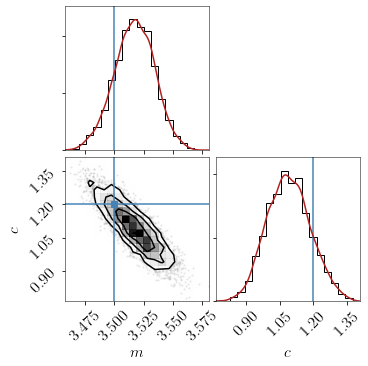

In [45]:
mchainjags = samples['m'].flatten()
cchainjags = samples['c'].flatten()

samples_pyjags = np.vstack((mchainjags, cchainjags)).T

resdict['mpyjags_mu'] = np.mean(samples_pyjags[:,0])      # mean of m samples
resdict['mpyjags_sig'] = np.std(samples_pyjags[:,0])      # standard deviation of m samples
resdict['cpyjags_mu'] = np.mean(samples_pyjags[:,1])      # mean of c samples
resdict['cpyjags_sig'] = np.std(samples_pyjags[:,1])      # standard deviation of c samples
resdict['ccpyjags'] = np.corrcoef(samples_pyjags.T)[0,1] # correlation coefficient between parameters

# plot using corner.py
plotposts(samples_pyjags)

In [46]:
# calculate the autocorrelation length
acts = []
for i, param in enumerate(["m", "c"]):
    acts.append(emcee.autocorr.integrated_time(samples_pystan[:, i]))
    print("Autocorrelation length for '{}' is {}".format(param, acts[-1]))
print("Maximum autocorrelation length is {0:.1f}".format(np.max(acts)))

resdict['esspyjags'] = int((len(samples_pyjags) / np.max(acts)) / timetfp)
print("Effective samples per second: {}".format(resdict['esspyjags']))

Autocorrelation length for 'm' is [1.02849256]
Autocorrelation length for 'c' is [0.99880072]
Maximum autocorrelation length is 1.0
Effective samples per second: 327


That ends our exploration of MCMC codes. We now move on to Nested Sampling!

## Nested Sampling

[Nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) ([Skilling, 2006](https://projecteuclid.org/euclid.ba/1340370944)) is a method to numerically perform the integral required to evaluate the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data given a particular model. This is not a value that is produced by most standard MCMC methods, but is a value that is very useful if wanting to do [Bayesian model comparison](https://en.wikipedia.org/wiki/Bayes_factor). Above, we defined the marginal likelihood, or _evidence_, as

$$
p(\mathbf{d}|I) = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta},I) p(\vec{\theta}|I) {\rm d}{\theta_i},
$$

but, we can make this more explicit for a given hypothesis, or model, $H_j$, by stating:

$$
p(\mathbf{d}|H_j, I) \equiv Z = \int^{\forall \theta_i \in \vec{\theta}} p(\mathbf{d}|\vec{\theta}, H_j, I) p(\vec{\theta}|H_j,I) {\rm d}{\theta_i},
$$

where previously the $H_j$ had been subsumed inside our implicit assumptions, $I$.

Nested sampling algorithms generally start by drawing a set of points (sometimes called _"live points"_, or _"active points"_) from the prior distribution. It relies on these points truely being independent draws from the prior, otherwise the resulting marginal likelihood value can be biased. The likelihood is evaluated at each point, and the smallest likelihood point is found. This points is then removed from the set of live points (and goes into the sum calculating the marginal likelihood integral) and a new point is drawn from the prior with the constraint that it has a likelihood larger than the just removed point. Drawing truely independent points from this constrained prior is the main tricky part of nested sampling (particularly when the number of parameters is not small), and a variety of methods (including MCMC methods) can be used.

The uncertainty on the estimate of the natural logarithm marginal likelihood, $\ln{Z}$, can be found if the information gain (or [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)), $h$, in going from the prior to the posterior is calculated. If $h$ (in [nats](https://en.wikipedia.org/wiki/Nat_%28unit%29)) is available then the uncertainty is ([Skilling, 2006](https://projecteuclid.org/euclid.ba/1340370944)):

$$
\sqrt{\frac{h}{N_{\rm live}}},
$$

where $N_{\rm live}$ is the number of live points used.

> **Note**: This is the statistical uncertainty on the value, but if there are any biases due to the sampling not being independent draws from the prior then there can be systematic uncertainties too.

As well as producing a value for the marginal likelihood, a by-product of the nested sampling algorithm to to produce a set of samples that can be re-sampled from to produce samples drawn from the posterior distribution.

> **Note**: MCMC methods can be used to estimate the marginal likelihood, e.g., `emcee` can be run with a [parallel tempering sampling method](http://dfm.io/emcee/current/user/pt/) and used to compute the evidence using thermodynamic integration (e.g., [Goggans & Chi, 2004](http://aip.scitation.org/doi/abs/10.1063/1.1751356)), or potentially using Slice sampling with PyMC3.

As with MCMC, there are various codes available to perform the nested sampling algorithm. We will again look at pure Python implementations and some that are wrappers to other libraries.

### Nestle

[Nestle](http://kylebarbary.com/nestle/) is a pure Python nested sampling algorithm. It has three options for the method with which it draws new samples: ["classic"](http://kylebarbary.com/nestle/#mcmc-exploration-method-classic), ["single ellipsoid"](http://kylebarbary.com/nestle/#single-ellipsoid-method-single), and ["multiple ellipsoids](http://kylebarbary.com/nestle/#multiple-ellipsoids-method-multi). In this example we'll make use of the last of these. This uses the MultiNest method (also see [PyMultiNest below](#PyMultiNest)) ([Feroz _et al_, 2009](https://arxiv.org/abs/0809.3437)) in which the current live points are clustered (however, clustering is not re-done at every iteration of the algorithm), ellipsoids completely bounding each cluster are found, an ellipsoid is randomly chosen with a probability proportional to its volume, and a new sample is drawn uniformly from it.

Nestle is available on PyPI and installable using `pip` with:

```bash
pip install nestle
```

The source code is available on GitHub [here](https://github.com/kbarbary/nestle).

The set up of likelihood functions is quite similar to that for [emcee](#emcee), but the prior that is used is a unit hypercube (an $n$-dimensional cube with all sides equal to one), so parameters must be mapped into this space. This is simple for uniform priors, but requires a [re-parameterisation](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables) using a [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) for more complex priors (if possible).

For our Gaussian prior on $m$ we can't analytically re-parameterise it for a unit hypercube, however we can use [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to take samples from a uniform range between 0 and 1, and convert them back to a Gaussian, e.g.

$$
m = \mu_m + \sqrt{2}\sigma_m {\rm erf}^{-1}\left(2c - 1\right),
$$

where $c \sim {\rm Uniform}(0,1)$ and ${\rm erf}^{-1}$ is the [inverse error function](https://en.wikipedia.org/wiki/Error_function#Inverse_functions). As [shown in the Nestle documentation](http://kylebarbary.com/nestle/prior.html#non-uniform-priors) we can use the [`scipy.special.ndtri`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ndtri.html#scipy.special.ndtri) function for this.

An example of using Nestle for the linear regression problem, but with uniform priors on both parameters, is given [here](http://kylebarbary.com/nestle/examples/plot_line.html#sphx-glr-examples-plot-line-py).

#### Setting the prior transform

Given the above description, rather than setting a prior function, we set a [prior transformation function](http://kylebarbary.com/nestle/prior.html) that maps from parameters drawn from the unit hypercube into the true parameters.

In [47]:
# import the inverse error function from scipy
from scipy.special import ndtri

def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)

#### Setting the likelihood function

This is similar to setting the likelihood function for [emcee](#Likelihood) except, as we're calculating the marginal likelihood, we will keep the normalisation constants. As before, we work with the natural logarithm of the likelihood function. The function can only take in a tuple variable containing the parameter values, so any additional required values must be hard coded, or set as global variables.

In [48]:
# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma) # natural log of the data noise standard deviation

def loglikelihood_nestle(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

Now you can run the sampler. We'll use 1024 live/active points (there's nothing special about this number, and powers of two are not required). The more live points you use the longer the code will take to run, but the uncertainty on the final marginal likelihood value will decrease with greater numbers of live points. 

Unlike with MCMCs, where you give it a number of iterations to run and after that point it stops, nested sampling needs to be supplied with a [stopping criterion](http://kylebarbary.com/nestle/stopping.html) at which point it will terminate. One common [criterion](http://kylebarbary.com/nestle/stopping.html#estimated-remaining-evidence) is based on the ratio between an estimate of the total evidence and the current calculated evidence value. Once this value gets below some set value the algorithm will terminate.

In [49]:
# import nestle
import nestle

print('Nestle version: {}'.format(nestle.__version__))

nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol = 0.1        # the stopping criterion

t0 = time()
res = nestle.sample(loglikelihood_nestle, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol)
t1 = time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

Nestle version: 0.2.0
Time taken to run 'Nestle' is 3.260874032974243 seconds


We can extract the value of the marginal likelihood, $\ln{Z}$, and its uncertainties with the following:

In [50]:
logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZnestle, logZerrnestle))

log(Z) = -87.96323528432879 ± 0.10193513274649987


A summary of the above values can also be output using:

In [51]:
print(res.summary())

niter: 14333
ncall: 23098
nsamples: 15357
logz: -87.963 +/-  0.102
h: 10.640


As mentioned above, the samples output by nested sampling are not drawn from the posterior, and as such need to be resampled from using certain weights. These weights are output by Nestle in the results. We can get posterior samples with the following:

In [52]:
# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]

resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

Number of posterior samples is 2808


Now we can plot the posteriors:

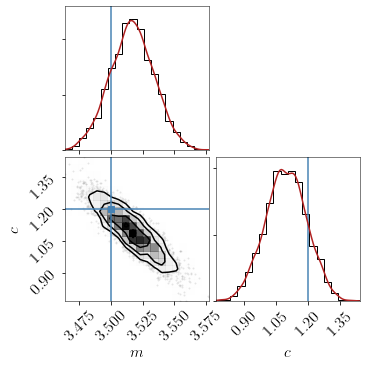

In [53]:
plotposts(samples_nestle)

With nested sampling the samples *should* be uncorrelated by construction (in reality, for some complex problems, *some* methods used to draw new samples within the nested sampling algorithm can leave correlations). During nested sampling, you can estimate the number of effective posterior samples from the full chain of samples using, for example, the effective sampler size calculation given [here](https://fredros.github.io/pypmc/html/tools.html#pypmc.tools.convergence.ess).

However, in all examples (as above) we've drawn posterior samples from the chains, so have the number of effective posterior samples. We can use this to calculate the number of effective samples per second to compare with the MCMC methods

In [54]:
resdict['essnestle'] = int(len(samples_nestle)/ timenestle)
print("Effective samples per second: {}".format(resdict['essnestle']))

Effective samples per second: 861


### CPNest

[CPNest](https://johnveitch.github.io/cpnest/) ([Veitch & del Pozzo, 2017](http://doi.org/10.5281/zenodo.835874)) is another pure Python nested sampling algorithm. To perform the sampling from the restricted prior it uses a [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) based MCMC, with sample proposal distributions that use a combination of the affine invarient ensemble methods described for [emcee](#emcee) ([Goodman & Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml)), [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution), or jumps based on the eigenvectors of the covariance matrix of live points.

CPNest is available on PyPI and can be installed using `pip` with: 

```bash
pip install cpnest
```

or via Conda [with](https://anaconda.org/conda-forge/cpnest):

```
conda install -c conda-forge cpnest
```

The source code is available on GitHub [here](https://github.com/johnveitch/cpnest/).

To run CPNest we have to define a [class](https://docs.python.org/3/tutorial/classes.html) containing the likelihood and prior functions. CPNest also requires explicit bounds on all parameters from which it will uniformly draw an initial set of live points. Prior to running the nested sampling algorithm, it will run an MCMC using the prior as the target distribution to make sure the samples are drawn from the required prior.

In [55]:
# import the Model class from CPNest
from cpnest.model import Model

LN2PI = np.log(2.*np.pi)

# set the model, likelihood and prior
class StraightLineModel(Model):
    """
    A simple straight line model, with a Gaussian likelihood.
    
    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        
    """
    names = ['m','c'] # parameter names (this is a required variables for the class)

    # define the boundaries using for initial sampling of the live points
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    cbounds = [cmin, cmax]
    # set the m bounds to be +/- 10sigma about the mean
    mbounds = [mmu-10.*msigma, mmu+10.*msigma]

    # NOTE: the bounds could instead be set through arguments passed to the __init__
    # function for the class if wanted
    bounds=[mbounds, cbounds] # upper and lower bounds on each parameter (required for the class)

    def __init__(self, data, abscissa, modelfunc, sigma):
        # set the data
        self._data = data         # oberserved data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

    def log_likelihood(self, params):
        """
        The natural logarithm of the likelihood function.

        Args:
            params (dict): a dictionary keyed to the parameter names.

        Returns:
            float: the log likelihood value.
        """
        # extract the parameters
        m = params['m']
        c = params['c']

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

    def log_prior(self,p):
        """
        The natural logarithm of the prior function.

        Args:
            p (dict): a dictionary keyed to parameter names.

        Returns:
            float: The log prior value.
        """
        # the uniform priors are dealt with by just checking that we're within the bounds
        if not self.in_bounds(p): return -np.inf # check parameters are all in bounds

        # Gaussian prior on m
        lp = 0.
        m = p['m']
        lp -= 0.5*((m-self.mmu)/self.msigma)**2 # no need for normalisation constant on the prior

        return lp

Checkpoint exception raise


We can now run CPNest. As with Nestle we will use 1024 live points. CPNest can use mutltiple CPU cores, but we'll set it to use one to be comparable to the other tests. The number of iterations used for the MCMC sampling is automatically worked out within the code by calculating autocorrelation lengths to see how many iterations are needed to produce independent samples, but a maximum chain length can also be set. We'll set this to 1024. As with Nestle a stopping criterion is required, which for CPNest is defined in the same way as Nestle. The current CPNest default is 0.1 and this cannot be altered by the user.

In [56]:
%%capture
# import cpnest
import cpnest

print('CPNest version: {}'.format(cpnest.__version__))

nlive = 1024      # number of live point
maxmcmc = 1024    # maximum MCMC chain length
nthreads = 1      # use one CPU core

# set up the algorithm
work = cpnest.CPNest(StraightLineModel(data, x, straight_line, sigma), verbose=0,
                     nthreads=nthreads, nlive=nlive, maxmcmc=maxmcmc);
# run the algorithm
t0 = time()
work.run();
t1 = time()

timecpnest = (t1-t0)

Running with 1 parallel threads
Sampler process 1310: MCMC samples accumulated = 0
Sampler process 1310 - mean acceptance 0.586: exiting
Final evidence: -87.75
Information: 10.45
Computed log_evidences: (-87.75582419873831,)
Relative weights of input files: [1.0]
Relative weights of input files taking into account their length: [1.0]
Number of input samples: [15138]
Expected number of samples from each input file [2734]
Samples produced: 2734


In [57]:
print("Time taken to run 'CPNest' is {} seconds".format(timecpnest))

Time taken to run 'CPNest' is 29.450788974761963 seconds


We can again extract the value of $\ln{Z}$ and its uncertainty. One simple bit of model comparison that we may want to do is compare the evidence for the model of the data containg a straight line (with the given priors on the parameter), with the evidence for a model that the data just contains independent Gaussian noise with the given standard deviation. We can calculate the latter evidence easily by just setting the model to zero in the log-likelihood function, e.g.:

$$
\ln{Z}_{\rm noise} = -\frac{M}{2}\ln{(2\pi)} - \ln\left(\prod_{i=1}^M \sigma_i\right) - \sum_{i=1}^M\frac{d_i^2}{2\sigma_i^2}.
$$

The natural logarithm of the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) comparing the two models is then:

$$
\ln{\mathcal{B}} = \ln{Z} - \ln{Z}_{\rm noise}.
$$

We will also extract this value.

In [58]:
logZcpnest = work.NS.logZ                     # value of log Z
infogaincpnest = work.NS.state.info           # value of the information gain
logZerrcpnest = np.sqrt(infogaincpnest/nlive) # estimate of the statistcal uncertainty on logZ

# get the null log likelihood (evidence that the data is Gaussian noise with zero mean, and given standard devaition)
logZnull = work.user.log_likelihood({'m': 0., 'c': 0.})

print("log(Z) = {} ± {}".format(logZcpnest, logZerrcpnest))

# output the log Bayes factor
print('log Bayes factor is {}'.format(logZcpnest - logZnull))

log(Z) = -87.75041035048207 ± 0.10099658485596845
log Bayes factor is 89069.71074769937


CPNest will itself resample from the nested samples to give posterior samples held in a dictionary, which we can plot.

Number of posterior samples is 2734


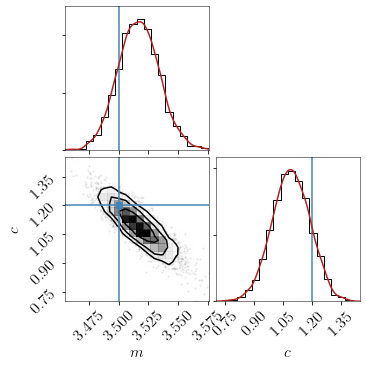

In [59]:
mchain_cpnest = work.posterior_samples['m'] # extract chain of m values
cchain_cpnest = work.posterior_samples['c'] # extract chain if c values
samples_cpnest = np.vstack((mchain_cpnest, cchain_cpnest)).T

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_cpnest.shape[0]))

resdict['mcpnest_mu'] = np.mean(samples_cpnest[:,0])      # mean of m samples
resdict['mcpnest_sig'] = np.std(samples_cpnest[:,0])      # standard deviation of m samples
resdict['ccpnest_mu'] = np.mean(samples_cpnest[:,1])      # mean of c samples
resdict['ccpnest_sig'] = np.std(samples_cpnest[:,1])      # standard deviation of c samples
resdict['cccpnest'] = np.corrcoef(samples_cpnest.T)[0,1]  # correlation coefficient between parameters
resdict['cpnest_npos'] = len(samples_cpnest)              # number of posterior samples
resdict['cpnest_time'] = timecpnest                       # run time
resdict['cpnest_logZ'] = logZcpnest                       # log marginalised likelihood
resdict['cpnest_logZerr'] = logZerrcpnest                 # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_cpnest)

In [60]:
resdict['esscpnest'] = int(len(samples_cpnest)/ timecpnest)
print("Effective samples per second: {}".format(resdict['esscpnest']))

Effective samples per second: 92


### dynesty

[dynesty](https://dynesty.readthedocs.io/en/latest/index.html) ([Speagle, 2019](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S/abstract)) is a pure Python-based implementation of the dynamic nested sampling algorithm ([Higson _et al_, 2017](https://arxiv.org/abs/1704.03459)). It is very similar in usage to [Nestle](#Nestle). Dynamic nested sampling is a way of dynamically adapting the number of live points used to provide more accurate evidence estimates and/or larger numbers of independent posterior samples. The code can run using dynamic adjustment of live points or just in a "static" mode with a fixed number of live points. There a many options for how the new live points are drawn, both in terms of the [bounds](https://dynesty.readthedocs.io/en/latest/quickstart.html#bounding-options) from which they are drawn and the [sampling](https://dynesty.readthedocs.io/en/latest/quickstart.html#sampling-options) from within those bounds. The bound options include the using bounding ellipsoids in the style of [MultiNest](#PyMultiNest), or the RadFriends algorithm of [UltraNest](#UltraNest), among others. The sampling options include uniform draws from the bounds, random walks, or slice sampling in the style of [PolyChord](#PyPolyChord). If not explicitly specified, dynesty will [select](https://dynesty.readthedocs.io/en/latest/quickstart.html#sampling-options) a sampling algorithm based on the number of dimensions of the problem being tackled.

dynesty is available on [PyPI](https://pypi.org/) and can be installed with `pip` using:

```bash
pip install dynesty
```

or using Conda [with](https://anaconda.org/conda-forge/dynesty):

```bash
conda install -c conda-forge dynesty
```

> **Note**: Other dynamic nested sampling codes exist such as [dyPolyChord](http://dypolychord.readthedocs.io/en/latest/) and [`perfectns`](https://github.com/ejhigson/perfectns).

The likelihood function and prior transform can be set up in a way that is identical to [Nestle](#Nestle) (we'll define both again below for completeness), with the differences being in how the sampler is called. Here we will show the sampling being used for both "*static*" and "*dynamic*" nested sampling.

In [61]:
# import the inverse error function from scipy
from scipy.special import ndtri

def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)


# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma) # natural log of the data noise standard deviation


def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

First we'll run with the "static" sampler. For consistency with [Nestle](#Nestle) and [CPNest](#CPNest) we'll use 1024 live points and a stopping criterion of 0.1. As with our [Nestle](#Example) we will use the [MultiNest](#PyMultiNest)-style bounding ellipsoids, but with [uniform](https://dynesty.readthedocs.io/en/latest/api.html#dynesty.sampling.sample_unif) sampling based on the low-dimensionality of the problem.

In [62]:
# import dynesty
import dynesty

print('dynesty version: {}'.format(dynesty.__version__))

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

from dynesty import NestedSampler

sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar
t1 = time()

timedynesty = (t1-t0)

print("Time taken to run 'dynesty' (in static mode) is {} seconds".format(timedynesty))

dynesty version: 1.0.1
Time taken to run 'dynesty' (in static mode) is 9.308077335357666 seconds


We can extract the value of the marginal likelihood, $\ln{⁡Z}$, and its uncertainties with the following:

In [63]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

log(Z) = -87.90781308682891 ± 0.14378250890834132


Or, get a summary of this information using:

In [64]:
print(res.summary())

Summary
nlive: 1024
niter: 14283
ncall: 58427
eff(%): 26.199
logz: -87.908 +/-  0.144
None


As with [Nestle](#Nestle) we need to draw posterior samples from the nested samples based on their prior weights.

Number of posterior samples is 15307


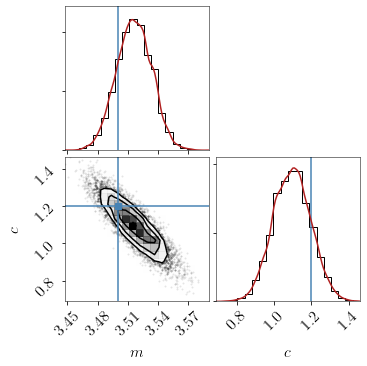

In [65]:
# get function that resamples from the nested samples to give sampler with equal weight
from dynesty.utils import resample_equal

# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)

resdict['mdynesty_mu'] = np.mean(samples_dynesty[:,0])      # mean of m samples
resdict['mdynesty_sig'] = np.std(samples_dynesty[:,0])      # standard deviation of m samples
resdict['cdynesty_mu'] = np.mean(samples_dynesty[:,1])      # mean of c samples
resdict['cdynesty_sig'] = np.std(samples_dynesty[:,1])      # standard deviation of c samples
resdict['ccdynesty'] = np.corrcoef(samples_dynesty.T)[0,1]  # correlation coefficient between parameters
resdict['dynesty_npos'] = len(samples_dynesty)              # number of posterior samples
resdict['dynesty_time'] = timedynesty                       # run time
resdict['dynesty_logZ'] = logZdynesty                       # log marginalised likelihood
resdict['dynesty_logZerr'] = logZerrdynesty                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_dynesty)))

# plot using corner.py
plotposts(samples_dynesty)

In [66]:
resdict['essdynesty'] = int(len(samples_dynesty)/ timedynesty)
print("Effective samples per second: {}".format(resdict['essdynesty']))

Effective samples per second: 1644


We can now do the same thing, but with the "dynamic" sampler. For this we can specify an initial number of live points (we will stick with 1024), but the actual number used will evolve. The [stopping criterion](https://dynesty.readthedocs.io/en/latest/dynamic.html#stopping-function) for the dynamic method is more complex than for the static case, and we will just leave it at the default values.

In [67]:
# import the dynamic nested sampler
from dynesty import DynamicNestedSampler

# set up the sampler
dsampler = DynamicNestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                                bound=bound, sample=sample)

# run the sampler (not that we have not included the dlogz tolerance)
t0 = time()
dsampler.run_nested(nlive_init=nlive, print_progress=False)
t1 = time()

timedynestydynamic = (t1-t0)

print("Time taken to run 'dynesty' (in dynamic mode) is {} seconds".format(timedynestydynamic))

Time taken to run 'dynesty' (in dynamic mode) is 614.5134539604187 seconds


Let's just compare the marginal likelihoods and numbers of posterior samples between the static and dynamic methods.

In [68]:
dres = dsampler.results # get results dictionary from sampler

logZdynestydynamic = dres.logz[-1]        # value of logZ
logZerrdynestydynamic = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("Static: log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))
print("Dynamic: log(Z) = {} ± {}".format(logZdynestydynamic, logZerrdynestydynamic))

# draw posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
samples_dynestydynamic = resample_equal(dres.samples, dweights)
print('Static: num. posterior samples: {}'.format(len(samples_dynesty)))
print('Dynamic: num. posterior samples: {}'.format(len(samples_dynestydynamic)))

Static: log(Z) = -87.90781308682891 ± 0.14378250890834132
Dynamic: log(Z) = -87.74736139202808 ± 0.14253397039493135
Static: num. posterior samples: 15307
Dynamic: num. posterior samples: 30686


### UltraNest

[UltraNest](https://johannesbuchner.github.io/UltraNest/) is Python-based implementation of the nested sampling, that contains several [sampling algorithms](https://johannesbuchner.github.io/UltraNest/method.html) designed for correctness of sampling. One particular method it provides is called RadFriends ([Buchner, 2014](https://arxiv.org/abs/1407.5459)) that is designed to be robust against effects caused by inaccuracies of drawing new samples from the constrained prior.

UltraNest is available from its [github repository](https://github.com/JohannesBuchner/UltraNest.git), but can be installed form PyPi using

```bash
pip install ultranest
```

or using Conda [with](https://anaconda.org/conda-forge/ultranest):

```bash
conda install -c conda-forge ultranest
```

Similarly to [Nestle](#Nestle) and [dynesty](#dynesty), UltraNest samples from a unit hypercube, and therefore you have to defined a [prior transformation function](#Setting-the-prior-transform), so we can set up these functions in a very similar way to what we have seen [above](#Nestle).

In [69]:
# define the prior transform

from scipy.special import ndtri

def prior_transform_ultranest(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (list): a list/array containing the parameters.
        
    Returns:
        list: a new list/array with the transformed parameters.
    """

    # unpack the parameters (in their unit hypercube form)
    mprime = theta[0]
    cprime = theta[1]

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return np.array([m, c])

We can again define the likelihood in a very similay way to [Nestle](#Nestle).

In [70]:
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

# define the Gaussian likelihood function
def loglikelihood_ultranest(theta):
    """
    The log-likelihood function.
    """

    # unpack the parameters
    m = theta[0]
    c = theta[1]

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

To run UltraNest we'll use the [`ReactiveNestedSampler`](https://johannesbuchner.github.io/UltraNest/ultranest.html#ultranest.integrator.ReactiveNestedSampler) method. Unlike other nested sampling methods, this does not require you to specify the number of live points to use. It will automatically adjust the number as required, starting with a default minimum of 400.

In [71]:
import ultranest

print('UltraNest version: {}'.format(ultranest.__version__))

# set the ReactiveNestedSampler method
sampler = ultranest.ReactiveNestedSampler(["m", "c"], loglikelihood_ultranest, prior_transform_ultranest)

ndims = 2         # two parameters
tol = 0.5         # the stopping criterion

# run the nested sampling algorithm
t0 = time()
result = sampler.run(dlogz=tol)
t1 = time()

timeultranest = (t1-t0)

2020-07-09, 11:03:29 - ultranest: Sampling 400 live points from prior ...
Sampling 400 live points from prior ...


UltraNest version: 2.2.1


2020-07-09, 11:03:40 - ultranest: Explored until L=-8e+01  
Explored until L=-8e+01  
2020-07-09, 11:03:40 - ultranest: Likelihood function evaluations: 8709
Likelihood function evaluations: 8709
2020-07-09, 11:03:43 - ultranest:   logZ = -87.67 +- 0.1356
  logZ = -87.67 +- 0.1356
2020-07-09, 11:03:43 - ultranest: Effective samples strategy satisfied (ESS = 1555.9, need >400)
Effective samples strategy satisfied (ESS = 1555.9, need >400)
2020-07-09, 11:03:43 - ultranest: Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
2020-07-09, 11:03:43 - ultranest: Evidency uncertainty strategy is satisfied (dlogz=0.27, need <0.5)
Evidency uncertainty strategy is satisfied (dlogz=0.27, need <0.5)
2020-07-09, 11:03:43 - ultranest:   logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.50
  logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.50
2020

In [72]:
print("Time taken to run 'UltraNest' is {} seconds".format(timeultranest))

Time taken to run 'UltraNest' is 13.918265104293823 seconds


We can extract the value of the marginal likelihood, $\ln{Z}$, and its uncertainties with the following:

In [73]:
logZultranest = result['logz']        # value of logZ
logZerrultranest = result['logzerr']  # estimate of the statistcal uncertainty on logZ

# output marginal likelihood
print("Marginalised evidence is {} ± {}".format(logZultranest, logZerrultranest))

Marginalised evidence is -87.6864801325525 ± 0.2730069227989279


We can now resample from the nested samples to get the posterior samples.

Number of posterior samples is 1072


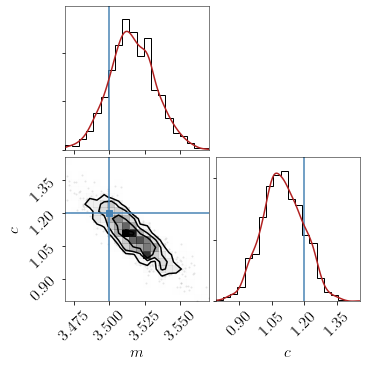

In [74]:
points = np.array(result["weighted_samples"]["points"])
weights = np.array(result["weighted_samples"]["weights"])
scaledweights = weights / weights.max()
mask = np.random.rand(len(scaledweights)) < scaledweights

samples_ultranest = points[mask, :]

resdict['multranest_mu'] = np.mean(samples_ultranest[:,0])      # mean of m samples
resdict['multranest_sig'] = np.std(samples_ultranest[:,0])      # standard deviation of m samples
resdict['cultranest_mu'] = np.mean(samples_ultranest[:,1])      # mean of c samples
resdict['cultranest_sig'] = np.std(samples_ultranest[:,1])      # standard deviation of c samples
resdict['ccultranest'] = np.corrcoef(samples_ultranest.T)[0,1]  # correlation coefficient between parameters
resdict['ultranest_npos'] = len(samples_ultranest)              # number of posterior samples
resdict['ultranest_time'] = timeultranest                       # run time
resdict['ultranest_logZ'] = logZultranest                       # log marginalised likelihood
resdict['ultranest_logZerr'] = logZerrultranest                 # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_ultranest)

print('Number of posterior samples is {}'.format(samples_ultranest.shape[0]))

In [75]:
resdict['essultranest'] = int(len(samples_ultranest)/ timeultranest)
print("Effective samples per second: {}".format(resdict['essultranest']))

Effective samples per second: 77


We will now look at some nested sampling algorithms that are not pure Python, but do have Python wrappers.

### PyMultiNest

[PyMultiNest](http://johannesbuchner.github.io/PyMultiNest/) ([Buchner _et al_, 2014](https://www.aanda.org/articles/aa/abs/2014/04/aa22971-13/aa22971-13.html)) is a wrapper to the popular [MultiNest](https://github.com/farhanferoz/MultiNest) code ([Feroz & Hobson, 2008](http://xxx.lanl.gov/abs/0704.3704) & [Feroz _et al_, 2009](http://xxx.lanl.gov/abs/0704.3704)), which has been particularly taken up by the astrophysics and cosmology community. The basics underlying MultiNest were described in relation to [Nestle](#Nestle), although MultiNest can use more sophisticated sampling methods, such as importance sampling ([Feroz _et al_, 2014](http://xxx.lanl.gov/abs/1306.2144v2)).

To use PyMultiNest, the MultiNest library itself must be installed (MultiNest can be downloaded from GitHub [here](https://github.com/farhanferoz/MultiNest)). Installation of PyMultiNest and its requirements are described [here](http://johannesbuchner.github.io/PyMultiNest/install.html); once MultiNest is installed you can then install PyMultiNest using `pip` with:

```bash
pip install pymultinest
```

A simpler solution, that comes bundled with MultiNest, is to install using [Conda](https://conda.io/en/latest/index.html) [with](https://anaconda.org/conda-forge/pymultinest):

```bash
conda install -c conda-forge pymultinest
```

> **Note**: If using MultiNest, and software wrapping it, for your work please note the software license restrictions [here](https://github.com/farhanferoz/MultiNest/blob/master/MultiNest_v3.11/LICENCE). 

Some examples of running PyMultiNest can be found [here](http://johannesbuchner.github.io/pymultinest-tutorial/), although an interface through a [`solver` function](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_demo.py) and [`Solver` class](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_solver_demo.py) are also available. We'll use the `Solver` class method, which can take in the same initialisation keyword arguments as the [`run()` method](http://johannesbuchner.github.io/PyMultiNest/pymultinest_run.html).

We use the `Solver` class to create a new class for our specific example. As with [CPNest](#CPNest) we use this class to define our log likeihood function, and like [Nestle](#Nestle) we define a prior transform to go from a unit hypercube to the true parameterisation. These functions can only take in arrays of the parameter values that we are exploring and cannot take in additional arguments. Therefore any additional values required must either be global variables, or a new `__init__` method for the class must be defined. We'll show the latter of these.

> **Note**: PyMultiNest is also available in Python through the [Monte Python](http://monte-python.readthedocs.io/en/latest/nested.html) package.

In [76]:
# import the Solver class
import pymultinest
from pymultinest.solve import Solver
from scipy.special import ndtri

LN2PI = np.log(2.*np.pi)

class StraightLineModelPyMultiNest(Solver):
    """
    A simple straight line model, with a Gaussian likelihood.

    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        **kwargs: keyword arguments for the run method
    """

    # define the prior parameters
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        # set the data
        self._data = data         # oberserved data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)

    def Prior(self, cube):
        """
        The prior transform going from the unit hypercube to the true parameters. This function
        has to be called "Prior".

        Args:
            cube (:class:`numpy.ndarray`): an array of values drawn from the unit hypercube

        Returns:
            :class:`numpy.ndarray`: an array of the transformed parameters
        """

        # extract values
        mprime = cube[0]
        cprime = cube[1]

        m = self.mmu + self.msigma*ndtri(mprime)      # convert back to m
        c = cprime*(self.cmax-self.cmin) + self.cmin  # convert back to c

        return np.array([m, c])

    def LogLikelihood(self, cube):
        """
        The log likelihood function. This function has to be called "LogLikelihood".

        Args:
            cube (:class:`numpy.ndarray`): an array of parameter values.

        Returns:
            float: the log likelihood value.
        """

        # extract parameters
        m = cube[0]
        c = cube[1]

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

Now we can run the sampler. As before we'll use 1024 live points, and like with [Nestle](#Nestle) we'll use a stopping criterion of 0.5. By default the sampler will use importance sampling.

In [77]:
nlive = 1024 # number of live points
ndim = 2     # number of parameters
tol = 0.5    # stopping criterion

# run the algorithm
t0 = time()
solution = StraightLineModelPyMultiNest(data, x, straight_line, sigma, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)

  analysing data from /tmp/tmpzkpbee4ppymultinest/.txt


In [78]:
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

Time taken to run 'PyMultiNest' is 6.444037675857544 seconds


Now we can extract the value of $\ln{Z}$ and its uncertainty.

In [79]:
logZpymnest = solution.logZ        # value of log Z
logZerrpymnest = solution.logZerr  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZpymnest, logZerrpymnest))

log(Z) = -87.64406802872726 ± 0.10040647303032434


These solutions, and the mean and standard deviation of the $m$ and $c$ parameters, can also be shown by using:

In [80]:
print(solution)

Model in "(temporary directory)" (2 dimensions)
Evidence ln Z = -87.6 +- 0.1
Parameter values:
   Parameter  1 : 3.517 +- 0.017
   Parameter  2 : 1.094 +- 0.099


We can extract and plot the posteriors. The `solution.samples` value contains an array of the posterior samples rather than the nested samples, so no resamping is required.

Number of posterior samples is 3523


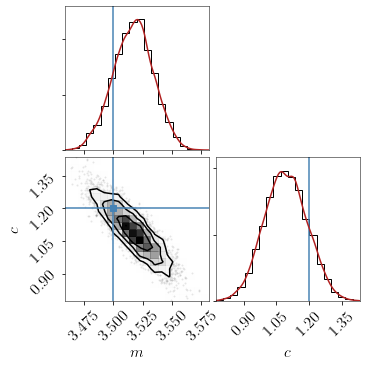

In [81]:
mchain_pymnest = solution.samples[:,0] # extract chain of m values
cchain_pymnest = solution.samples[:,1] # extract chain if c values

samples_pymnest = np.vstack((mchain_pymnest, cchain_pymnest)).T

resdict['mpymnest_mu'] = np.mean(samples_pymnest[:,0])      # mean of m samples
resdict['mpymnest_sig'] = np.std(samples_pymnest[:,0])      # standard deviation of m samples
resdict['cpymnest_mu'] = np.mean(samples_pymnest[:,1])      # mean of c samples
resdict['cpymnest_sig'] = np.std(samples_pymnest[:,1])      # standard deviation of c samples
resdict['ccpymnest'] = np.corrcoef(samples_pymnest.T)[0,1]  # correlation coefficient between parameters
resdict['pymnest_npos'] = len(samples_pymnest)              # number of posterior samples
resdict['pymnest_time'] = timepymultinest                   # run time
resdict['pymnest_logZ'] = logZpymnest                       # log marginalised likelihood
resdict['pymnest_logZerr'] = logZerrpymnest                 # uncertainty on log(Z)

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_pymnest.shape[0]))

# plot using corner.py
plotposts(samples_pymnest)

In [84]:
resdict['esspymnest'] = int(len(samples_pymnest)/ timepymultinest)
print("Effective samples per second: {}".format(resdict['esspymnest']))

Effective samples per second: 546


### DNest4

[DNest4](https://github.com/eggplantbren/DNest4) ([Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757)) uses a nested sampling algorithm called _Diffusive Nested Sampling_ ([Brewer _et al_, 2011](https://arxiv.org/abs/0912.2380)). The main difference between this method and others is that it can at any point still propose samples throughout the whole prior, rather than being contrained to draw points within a range based on the current set of live points. This allows it to find volumes of high likelihood that might be missed by other methods because they lie in an area where no live points remain, i.e. it is good for sampling multi-model posteriors. It can also be used in cases where the number of parameters in the model that is being fit is itself a variable, e.g., if the line model could either be a straight line, or a quadratic, or a cubic. The method used is called a Reversible Jump MCMC ([Green, 1995](https://academic.oup.com/biomet/article/82/4/711/252058)), although this is not currently available in the Python interface for DNest4.

An example of using the Python wrapper for DNest4 for a straight line mode is given [here](https://github.com/eggplantbren/DNest4/blob/master/python/examples/straightline/straightline.py), but we will reproduce it with minor modifications (in that example $\sigma$ is also included in the fitting).

You can install the development version of DNest4 by cloning it from its [GitHub repository](https://github.com/eggplantbren/DNest4) and following the instructions [here](https://github.com/eggplantbren/DNest4#compiling). However, the Python interace can be installed from [PyPI](https://pypi.org/project/dnest4/) via pip with

```bash
pip install dnest4
```

or through Conda [with](https://anaconda.org/conda-forge/dnest4)

```bash
conda install -c conda-forge dnest4 
```

For DNest4 we need to create a `Model` class that contains the following methods:
 * `from_prior()`: a function that draws a sample from the prior distributions of the parameters
 * `perturb()`: a function that proposes new sample values
 * `log_likelihood()`: the natural logarithm of the likelihood function

The `perturb()` method also needs to calculate the natural logarithm of the [Metropolis-Hastings ratio](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) required to give the acceptance probability:

$$
H = \frac{p(\theta'|I)}{p(\theta|I)} \frac{g(\theta|\theta')}{g(\theta'|\theta)},
$$

where the first ratio on the right-hand-side is the ratio of priors at the proposed point $\theta'$ and current point $\theta$, and the second ratio of the ratio of the proposal distributions. In our case the proposal distribution is symmetric, so its ratio is unity, and the ratio of the prior depends on the Gaussian prior on $m$, but not on the uniform prior for $c$.

Parameters cannot be passed to the class on initialisation, so things such as the data must be global variables.

In [85]:
# import randh function, which draws points from a heavy-tailed distribution, and wrapm which wraps a point within a given range
from dnest4 import randh, wrap

LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

# define prior range values as global variables
cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

mmu = 0.     # mean of the Gaussian prior on m
msigma = 10. # standard deviation of the Gaussian prior on m

class DNest4Model(object):
    """
    Specify the model in Python.
    """
    def __init__(self):
        """
        Parameter values *are not* stored inside the class
        """
        pass

    def from_prior(self):
        """
        Draw points from the prior distribution.

        Returns:
            :class:`np.ndarray`: a numpy array containing the parameter values.
        """

        m = np.random.normal(mmu, msigma)
        c = np.random.uniform(cmin,  cmax)

        return np.array([m, c])

    def perturb(self, params):
        """
        Perturb the current parameters by proposing a new position. This takes a numpy array of
        parameters as input, and modifies it in-place. In just perturbs one parameter at a time.

        Args:
            params (:class:`np.ndarray`): the current parameters (this is modified by the function)

        Returns:
            float: the natural logarithm of the Metropolis-Hastings proposal ratio.
        """
        logH = 0.0 # log of the Metropolis-Hastings prior x proposal ratio

        # randomly choose which parameter to perturb 
        which = np.random.randint(len(params))
        mmu = 0.
        msigma = 10.
        if which == 0:
            # update H for Gaussian prior
            logH -= -0.5*((params[which]-mmu)/msigma)**2

        params[which] += 1.*randh() # we could scale this or use different distributions for each parameter, but in our case we know our distribution is quite compact and unimodal

        if which == 0:
            # update H for Gaussian prior
            logH += -0.5*((params[which]-mmu)/msigma)**2
        else:
            # wrap c value so that it stays within the prior range
            params[which] = wrap(params[which], cmin, cmax)

        return logH

    def log_likelihood(self, params):
        """
        Gaussian sampling distribution.
        """
        m, c = params # unpack parameters
        
        norm = -0.5*M*LN2PI - M*LNSIGMA
        chisq = np.sum(((data - straight_line(x, m, c))/sigma)**2)
        return norm - 0.5*chisq

We can now run the sampler. The values that are passed to the sampler are described in Section 7 of [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757), but we'll stick with the defaults used in the [example code](https://github.com/eggplantbren/DNest4/blob/master/python/examples/straightline/straightline.py). Unlike with the other nested sampling algorithms we do not pass a tolerance for the stopping criterion, but just specify the number of levels and steps to perform. The `num_steps` gives to total number of MCMC iterations, but if not set the code will run forever by default, until the process is killed by the user.

In [86]:
# import dnest4
import dnest4

print('DNest4 version: {}'.format(dnest4.__version__))

# Create a model object and a sampler
model = DNest4Model()
sampler = dnest4.DNest4Sampler(model, backend=dnest4.backends.CSVBackend(".", sep=" "))

# Set up the sampler. The first argument is max_num_levels
gen = sampler.sample(max_num_levels=30, num_steps=1000, new_level_interval=10000,
                     num_per_step=10000, thread_steps=100, num_particles=5, lam=10, beta=100)

# Do the sampling (one iteration here = one particle save)
t0 = time()
for sample in enumerate(gen):
    pass
t1 = time()

timednest4 = (t1-t0)

print("Time taken to run 'DNest4' is {} seconds".format(timednest4))

DNest4 version: 0.2.4
Time taken to run 'DNest4' is 672.2984502315521 seconds


To create the posterior samples the output of DNest4 has to be processed, which can be performed using the `postprocess()` function. Once this is done the posterior samples will be held in a `posterior_sample.txt` file containing a column for each parameter. As stated in [Brewer & Foreman-Mackey, 2016](https://arxiv.org/abs/1606.03757):

> _"it is harder to compute justified error bars on $\ln{(Z)}$ in DNS than it is in standard NS."_

so we will not quote a value here.

In [87]:
# Run the postprocessing to get marginal likelihood and generate posterior samples
logZdnest4, infogaindnest4, _ = dnest4.postprocess(plot=False);

samples_dnest4 = np.loadtxt('posterior_sample.txt')

log(Z) = -88.51712939746874
Information = 11.200256283288226 nats.
Effective sample size = 172.28558148912012


Now let's plot the posteriors (noting that the effective number of posterior samples is quite a bit smaller than for the other samplers).

Number of posterior samples is 172


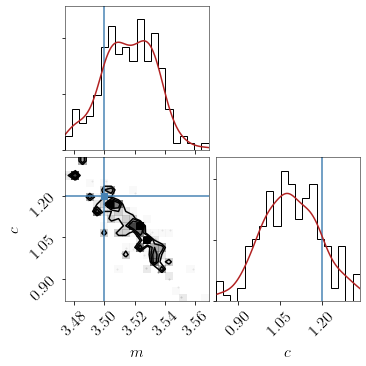

In [88]:
# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_dnest4.shape[0]))

resdict['mdnest4_mu'] = np.mean(samples_dnest4[:,0])      # mean of m samples
resdict['mdnest4_sig'] = np.std(samples_dnest4[:,0])      # standard deviation of m samples
resdict['cdnest4_mu'] = np.mean(samples_dnest4[:,1])      # mean of c samples
resdict['cdnest4_sig'] = np.std(samples_dnest4[:,1])      # standard deviation of c samples
resdict['ccdnest4'] = np.corrcoef(samples_dnest4.T)[0,1]  # correlation coefficient between parameters
resdict['dnest4_npos'] = len(samples_dnest4)              # number of posterior samples
resdict['dnest4_time'] = timednest4                       # run time
resdict['dnest4_logZ'] = logZdnest4                       # log marginalised likelihood

# plot using corner.py
plotposts(samples_dnest4)

In [98]:
resdict['essdnest4'] = len(samples_dnest4)/ timednest4
print("Effective samples per second: {0:.2f}".format(resdict['essdnest4']))

Effective samples per second: 0.26


### PyPolyChord

[PolyChord](https://github.com/PolyChord/PolyChordLite) ([Handley _et al_, 2015a](https://arxiv.org/abs/1502.01856), [Handley *et al*, 2015b](https://arxiv.org/abs/1506.00171)) is a nested sampling implementation that uses [slice sampling](https://en.wikipedia.org/wiki/Slice_sampling) when drawing new points from the constrained prior.

The PolyChord package itself provides a Python interface called PyPolyChord for using the algorithm. PolyChord can be downloaded from Github [here](https://github.com/PolyChord/PolyChordLite) with:

```bash
git clone https://github.com/PolyChord/PolyChordLite.git
```

PyPolyChord can then be installed with

```bash
cd PolyChordLite
python setup.py install
```

The installation will attempt to find a copy of the `libmpi.so` library. If you have not got MPI (or are having further problems with MPI) you can disable it by instead installing with:

```bash
python setup.py --no-mpi install
```

As with [Nestle](#Nestle) and [PyMultiNest](#PyMultiNest) PolyChord samples from a unit hypercube, so you need to define a prior transform function. We also need a log likelihood function. These can be very similar to those used for [Nestle](#Nestle), but the functions must take in and output list rather than lists or tuples. Values such as the data array cannot be passed to the functions explicitly, so must be set as global variables.

> **Note**: If using PolyChord for your work, please note the license restrictions described [here](https://github.com/PolyChord/PolyChordLite/blob/master/LICENCE).

In [90]:
from scipy.special import ndtri

LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

def prior_transform_polychord(cube):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        cube (array, list): a list containing the parameters as drawn from a unit hypercube.

    Returns:
        list: the transformed parameters.
    """

    # unpack the parameters (in their unit hypercube form)
    mprime = cube[0]
    cprime = cube[1]
    
    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    theta = [m, c]

    return theta


def loglikelihood_polychord(theta):
    """
    The log-likelihood function.

    Args:
        theta (array, list): the set of parameter values.

    Returns:
        float: the log-likelihood value.
        list: A list of any derived parameters (an empty list if there are none).
    """

    # unpack the parameters
    m = theta[0]
    c = theta[1]

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq, []

As before we'll use 1024 live points (the default is to use 25 times the dimensionality of the problem) and a stopping criterion of 0.5 (the default value is 0.001). The current version of PyPolyChord will return values of the marginal likelihood and its uncertainty from the `PyPolyChord` object that runs the algorithm, but the class does not currently contain the posterior samples. It instead outputs these to files. The location of these files is set by setting the keyword arguments `base_dir` (defaults to "`chains`") and `file_root` (defaults to "`test`") in a `PolyChordSettings` object. This sets `{root} = {base_dir}/{file_root}`, and with this the posterior samples can be found in `{root}.txt` and the other statistics found in `{root}.stats`.

You may find that codes produce a "Segmentation Fault" soon after they start running. The PolyChord documentation says:

> "*The slice sampling & clustering steps use a recursive procedure. The default memory allocated to recursive 
> procedures is embarassingly small (to guard against memory leaks).*"

and the solution is to:

> Try increasing the stack size:  
> Linux:    `ulimit -s unlimited`  
> OSX:      `ulimit -s hard`

Alternatively, within a Python script you can achieve this using the [`resource`](https://docs.python.org/2/library/resource.html) module, as shown below.

In [91]:
import resource
curlimit = resource.getrlimit(resource.RLIMIT_STACK)
resource.setrlimit(resource.RLIMIT_STACK, (resource.RLIM_INFINITY,resource.RLIM_INFINITY))

In [92]:
nlive = 1024   # number of live points
ndims = 2      # number of parameters
nderived = 0   # number of derived parameters (this is zero)
tol = 0.5      # stopping criterion
basedir = os.path.join(os.getcwd(), 'polychord')  # output base directory
if not os.path.isdir(basedir):
    os.makedirs(basedir)                          # create base directory
    os.makedirs(os.path.join(basedir, 'clusters'))
fileroot = 'straightline'                         # output file name
broot = os.path.join(basedir, fileroot)

# import PolyChord
import pypolychord
from pypolychord.settings import PolyChordSettings  # class for passing setup information
from pypolychord.priors import UniformPrior         # pre-defined class for a uniform prior

# setup run settings using the PolyChordSetting class
pargs = {'nlive': nlive,
         'precision_criterion': tol,
         'base_dir': basedir,
         'file_root': fileroot,
         'write_resume': False, # don't output a resume file
         'read_resume': False}  # don't read a resume file
settings = PolyChordSettings(ndims, nderived, **pargs)

t0 = time()
output = pypolychord.run_polychord(loglikelihood_polychord, ndims, nderived, settings, prior_transform_polychord)
t1 = time()

timepolychord = (t1-t0)

print("Time taken to run 'PyPolyChord' is {} seconds".format(timepolychord))

# reset stack resource limit
resource.setrlimit(resource.RLIMIT_STACK, curlimit)

Time taken to run 'PyPolyChord' is 38.74254775047302 seconds


We can extract the marginal likelihood and the uncertainty from the `output` variable. 

In [93]:
print("log(Z) = {} ± {}".format(output.logZ, output.logZerr))

log(Z) = -87.9204255196021 ± 0.102183284447494


We can also extract the posterior samples from the file with the `_equal_weights.txt` suffix. Given we have two parameters, the chains for these will be the final two columns within the samples file.

Number of posterior samples is 2518


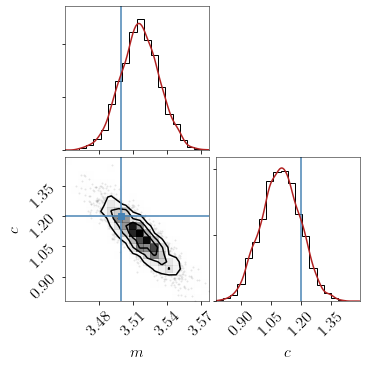

In [94]:
samplefile = broot+'_equal_weights.txt'
samples_polychord = np.loadtxt(samplefile)
samples_polychord = samples_polychord[:,-ndims:] # extract the last 'ndims' columns

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_polychord.shape[0]))

resdict['mpolychord_mu'] = np.mean(samples_polychord[:,0])      # mean of m samples
resdict['mpolychord_sig'] = np.std(samples_polychord[:,0])      # standard deviation of m samples
resdict['cpolychord_mu'] = np.mean(samples_polychord[:,1])      # mean of c samples
resdict['cpolychord_sig'] = np.std(samples_polychord[:,1])      # standard deviation of c samples
resdict['ccpolychord'] = np.corrcoef(samples_polychord.T)[0,1]  # correlation coefficient between parameters
resdict['polychord_npos'] = len(samples_polychord)              # number of posterior samples
resdict['polychord_time'] = timepolychord                       # run time
resdict['polychord_logZ'] = output.logZ                         # log marginalised likelihood
resdict['polychord_logZerr'] = output.logZerr                   # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_polychord)

In [95]:
resdict['esspolychord'] = int(len(samples_polychord)/ timepolychord)
print("Effective samples per second: {}".format(resdict['esspolychord']))

Effective samples per second: 64


## Summary

The timings given in this notebook are not directly comparable as the various codes have not been run with identical settings, and the number of likelihood evaluations produced can be quite different. But, they may be helpful in providing a rough ball-park of expected run times. As mentioned in relation to [emcee above](#emcee), it is important to note that different samplers will produce different numbers of truly independent samples, so some methods that may take longer to run may actually give more independent samples. Therefore comparisons of the number of effective samples per second may be more useful, although these will still be quite problem dependent. It is also worth noting that some of the codes can make use or multiple CPU cores, or GPUs, but these have not been used here. So, speed-ups could be achieved by using these in-built parallelisations.

The number of posterior samples produced by the nested sampling codes can depend strongly on the number of initial live points used. However, for the codes where we have specified a number of live points the final posterior sizes are very comparable. It should be noted that comparing posterior sample sizes and run times for DNest4 in particular is not entirely fair, as it is designed with more complex problems in mind and is not created to be efficient at simple examples where other methods work easily.

Something that is also worth noting, in particular with regard to nested sampling algorithms, is that they will generally take longer to run when there is a larger degree of difference between the prior and the posterior (i.e., the data contains a lot of new information, which, in technical terms, is called having a large [Kullback-Liebler (KL) diveregnce](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)). So, estimating the parameters of a model when the data contains a high signal-to-noise ratio signal will often take longer than the same model but with a weaker signal in the data.

Now, let's overplot everything (it will look a bit horrific)!

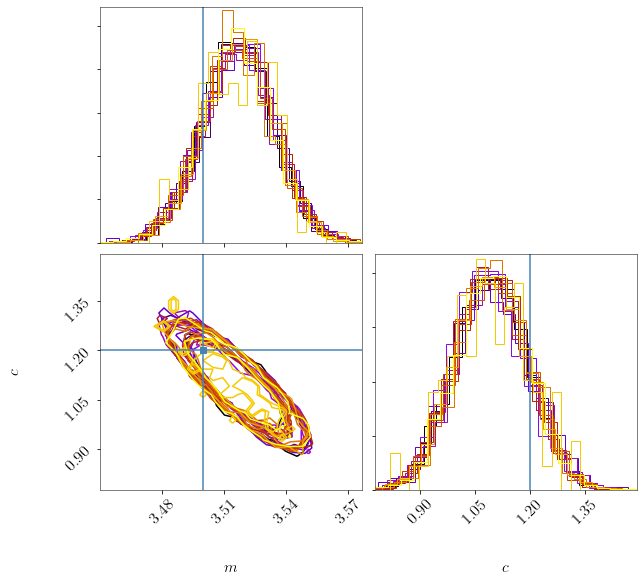

In [96]:
from matplotlib.pyplot import cm 
from matplotlib.colors import to_hex

# get a list of all the samples
chains = [samples_emcee, samples_pymc3, samples_pymc4, samples_zeus, samples_tfp, samples_pystan,
          samples_pyjags, samples_nestle, samples_cpnest, samples_dynesty, samples_ultranest,
          samples_pymnest, samples_dnest4, samples_polychord]

color = cm.gnuplot(np.linspace(0, 1, len(chains)))

hist2dkwargs = {'plot_datapoints': False,
                'plot_density': False,
                'levels': 1.0 - np.exp(-0.5 * np.arange(1.5, 2.1, 0.5) ** 2)} # roughly 1 and 2 sigma

for i, chain in enumerate(chains):
    cv = to_hex(color[i])
    if i == 0:
        fig = corner.corner(
            chain,
            labels=[r"$m$", r"$c$"],
            color=cv,
            hist_kwargs={'density': True},
            **hist2dkwargs,
        )
    else:
        if i < len(chains)-1:
            corner.corner(
                chain,
                labels=[r"$m$", r"$c$"],
                fig=fig,
                color=cv,
                hist_kwargs={'density': True},
                **hist2dkwargs,
            )
        else: # plot true values on last plot
            corner.corner(
                chain,
                labels=[r"$m$", r"$c$"],
                truths=[m, c],
                fig=fig,
                color=cv,
                hist_kwargs={'density': True},
                **hist2dkwargs,
            )
            
fig.set_size_inches(10.0, 9.0)

In [101]:
from IPython.display import Markdown

outputtable = """
| Sampler | $m$ | $c$ | corr. coeff | Effective samples / s |
|--- | :---: | :---: | :---: | :---: |
| emcee | {memcee_mu:.3f} ± {memcee_sig:.3f} | {cemcee_mu:.3f} ± {cemcee_sig:.3f} | {ccemcee:.3f} | {essemcee:d} |
| PyMC3 | {mpymc3_mu:.3f} ± {mpymc3_sig:.3f} | {cpymc3_mu:.3f} ± {cpymc3_sig:.3f} | {ccpymc3:.3f} | {esspymc3:d} |
| PyMC4 | {mpymc4_mu:.3f} ± {mpymc4_sig:.3f} | {cpymc4_mu:.3f} ± {cpymc4_sig:.3f} | {ccpymc4:.3f} | {esspymc4:d} |
| TFP | {mtfp_mu:.3f} ± {mtfp_sig:.3f} | {ctfp_mu:.3f} ± {ctfp_sig:.3f} | {cctfp:.3f} | {esstfp:d} |
| emcee | {mzeus_mu:.3f} ± {mzeus_sig:.3f} | {czeus_mu:.3f} ± {czeus_sig:.3f} | {cczeus:.3f} | {esszeus:d} |
| PyStan | {mpystan_mu:.3f} ± {mpystan_sig:.3f} | {cpystan_mu:.3f} ± {cpystan_sig:.3f} | {ccpystan:.3f} | {esspystan:d} |
| PyJAGS | {mpyjags_mu:.3f} ± {mpyjags_sig:.3f} | {cpyjags_mu:.3f} ± {cpyjags_sig:.3f} | {ccpyjags:.3f} | {esspyjags:d} |
| Nestle | {mnestle_mu:.3f} ± {mnestle_sig:.3f} | {cnestle_mu:.3f} ± {cnestle_sig:.3f} | {ccnestle:.3f} | {essnestle:d} |
| CPNest | {mcpnest_mu:.3f} ± {mcpnest_sig:.3f} | {ccpnest_mu:.3f} ± {ccpnest_sig:.3f} | {cccpnest:.3f} | {esscpnest:d} |
| dynesty | {mdynesty_mu:.3f} ± {mdynesty_sig:.3f} | {cdynesty_mu:.3f} ± {cdynesty_sig:.3f} | {ccdynesty:.3f} | {essdynesty:d} |
| UltraNest | {multranest_mu:.3f} ± {multranest_sig:.3f} | {cultranest_mu:.3f} ± {cultranest_sig:.3f} | {ccultranest:.3f} | {essultranest:d} |
| PyMultiNest | {mpymnest_mu:.3f} ± {mpymnest_sig:.3f} | {cpymnest_mu:.3f} ± {cpymnest_sig:.3f} | {ccpymnest:.3f} | {esspymnest:d} |
| DNest4 | {mdnest4_mu:.3f} ± {mdnest4_sig:.3f} | {cdnest4_mu:.3f} ± {cdnest4_sig:.3f} | {ccdnest4:.3f} | {essdnest4:.2f} |
| PyPolyChord | {mpolychord_mu:.3f} ± {mpolychord_sig:.3f} | {cpolychord_mu:.3f} ± {cpolychord_sig:.3f} | {ccpolychord:.3f} | {esspolychord:d} |
"""

Markdown(outputtable.format(**resdict))


| Sampler | $m$ | $c$ | corr. coeff | Effective samples / s |
|--- | :---: | :---: | :---: | :---: |
| emcee | 3.517 ± 0.018 | 1.095 ± 0.102 | -0.869 | 297 |
| PyMC3 | 3.517 ± 0.017 | 1.093 ± 0.099 | -0.864 | 15 |
| PyMC4 | 3.516 ± 0.018 | 1.099 ± 0.108 | -0.874 | 4 |
| TFP | 3.517 ± 0.018 | 1.082 ± 0.099 | -0.882 | 4 |
| emcee | 3.517 ± 0.017 | 1.096 ± 0.099 | -0.864 | 240 |
| PyStan | 3.516 ± 0.018 | 1.100 ± 0.101 | -0.875 | 163 |
| PyJAGS | 3.517 ± 0.017 | 1.091 ± 0.097 | -0.855 | 327 |
| Nestle | 3.517 ± 0.017 | 1.096 ± 0.097 | -0.867 | 861 |
| CPNest | 3.517 ± 0.017 | 1.093 ± 0.099 | -0.856 | 92 |
| dynesty | 3.516 ± 0.017 | 1.096 ± 0.100 | -0.867 | 1644 |
| UltraNest | 3.516 ± 0.016 | 1.100 ± 0.094 | -0.863 | 77 |
| PyMultiNest | 3.517 ± 0.017 | 1.094 ± 0.099 | -0.864 | 546 |
| DNest4 | 3.516 ± 0.018 | 1.091 ± 0.105 | -0.878 | 0.26 |
| PyPolyChord | 3.516 ± 0.017 | 1.098 ± 0.098 | -0.862 | 64 |


In [102]:
outputnest = """
#### Nested sampling

| Sampler | $\ln{{Z}}$ | num. posterior samples | run time (s) |
| --- | --- | :---: | --- |
| Nestle | {nestle_logZ:.3f} ± {nestle_logZerr:.3f} | {nestle_npos} | {nestle_time:.3f} |
| CPNest | {cpnest_logZ:.3f} ± {cpnest_logZerr:.3f} | {cpnest_npos} | {cpnest_time:.3f} |
| dynesty | {dynesty_logZ:.3f} ± {dynesty_logZerr:.3f} | {dynesty_npos} | {dynesty_time:.3f} |
| UltraNest | {ultranest_logZ:.3f} ± {ultranest_logZerr:.3f} | {ultranest_npos} | {ultranest_time:.3f} |
| PyMultiNest | {pymnest_logZ:.3f} ± {pymnest_logZerr:.3f} | {pymnest_npos} | {pymnest_time:.3f} |
| DNest4 | {dnest4_logZ:.3f} | {dnest4_npos} | {dnest4_time:.3f} |
| PyPolyChord| {polychord_logZ:.3f} ± {polychord_logZerr:.3f} | {polychord_npos} | {polychord_time:.3f} |
"""

Markdown(outputnest.format(**resdict))


#### Nested sampling

| Sampler | $\ln{Z}$ | num. posterior samples | run time (s) |
| --- | --- | :---: | --- |
| Nestle | -87.963 ± 0.102 | 2808 | 3.261 |
| CPNest | -87.750 ± 0.101 | 2734 | 29.451 |
| dynesty | -87.908 ± 0.144 | 15307 | 9.308 |
| UltraNest | -87.686 ± 0.273 | 1072 | 13.918 |
| PyMultiNest | -87.644 ± 0.100 | 3523 | 6.444 |
| DNest4 | -88.517 | 172 | 672.298 |
| PyPolyChord| -87.920 ± 0.102 | 2518 | 38.743 |


In [106]:
import cpuinfo
print('This was run on a single core "{}" CPU'.format(cpuinfo.get_cpu_info()['brand_raw']))

This was run on a single core "Intel(R) Core(TM) i5-4300U CPU @ 1.90GHz" CPU


## Running this notebook

I have created a [Docker image](https://hub.docker.com/r/mattpitkin/samplers/tags/), available on [Docker Hub](https://hub.docker.com/), in which Python 3 and all the above samplers are installed (this is roughly 8 Gb in size, so may take some time to download). This can be used to run this notebook in [Jupyter](http://jupyter.org/). You can download this notebook from [here](http://mattpitkin.github.io/samplers-demo/downloads/notebooks/Samplers.ipynb).

If you have Docker installed then under Linux, Mac OS or Windows you can run the notebook by opening a terminal (e.g., the Powershell in Windows) and running:

```bash
sudo docker run -i -t -p 8888:8888 -v ${notebook_location}:/samplers mattpitkin/samplers:python3 /bin/bash -c "jupyter notebook --notebook-dir=/samplers --ip='*' --port=8888 --no-browser --allow-root --MultiKernelManager.default_kernel_name=Samplers"
```

where `{notebook_location}` is replaced with the path containing the downloaded notebook. This will provide a link that can be pasted into your browser to show the notebook, and the `Samplers.ipynb` file can be selected. Under Windows remove the `sudo` from the above command.